In [8]:
# Change the working directory
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks')
!pwd

/content/drive/MyDrive/Colab_Notebooks


# Gas classification


This tutorial shows you how to train a machine learning model with a custom dataset for indoor gas classification.

In this notebook, you use TensorFlow to accomplish the following:

1. Import and preprocess a Gas dataset that contains: Normal Air, Coffee beans, Food coffee
2. Build a simple Neural network model
3. Train the model
4. Evaluate the model's effectiveness
5. Convert the model into .tflite format and add metadata for it

## TensorFlow programming

This tutorial demonstrates the following TensorFlow programming tasks:
* Building models and layers with the [Keras API](https://www.tensorflow.org/guide/keras/)


# A. Neural network

## 1. Import libraries

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

print("Tensorflow version: {}".format(tf.__version__))
print("Tensorflow datasets version; ", tfds.__version__)

Tensorflow version: 2.12.0
Tensorflow datasets version;  4.9.2


Install `tflite-support` package for adding metadata to `tflite` model.

In [10]:
!pip install tflite-support

In [11]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## I. Training with data from Kit

In [12]:
def get_hour(df, time_str='real_time_clock'):
  # Convert 'unix_time' column to datetime objects
  df[time_str] = pd.to_datetime(df[time_str], unit='s')

  # Find the minimum and maximum datetime values
  min_time = df[time_str].min()
  max_time = df[time_str].max()

  # Calculate the time difference between the first and last samples
  time_difference = max_time - min_time

  # Convert the time difference to hours
  time_difference_hours = time_difference.total_seconds() / 3600

  return time_difference_hours

### 1. Import dataset
Get raw data from Dev-kit files.

Gas 1: Normal Air

In [13]:
na_0206 = pd.read_csv('./Raw_data/dataset/normal_air/NormalAir_02_06_23.csv')
na_0206.shape

(93923, 12)

In [14]:
na_2806 = pd.read_csv('./Raw_data/dataset/normal_air/NormalAir_28_06_23.csv')
na_2806.shape

(713157, 12)

In [15]:
na_2807 = pd.read_csv('./Raw_data/dataset/normal_air/NormalAir_28_07_23.csv')
na_2807.shape

(135899, 12)

Gas 2: Caffee

In [16]:
cf_0206 = pd.read_csv('./Raw_data/dataset/caffee_beans/Caffee_02_06_23.csv')
cf_0206.shape

(180905, 12)

In [17]:
cf_2906 = pd.read_csv('./Raw_data/dataset/caffee_beans/Caffee_29_06_23.csv')
cf_2906.shape

(517511, 12)

In [18]:
cf_2807 = pd.read_csv('./Raw_data/dataset/caffee_beans/Caffee_28_07_23.csv')
cf_3007 = pd.read_csv('./Raw_data/dataset/caffee_beans/Caffee_30_07_23.csv')

Gas 3: Food Caffee

In [19]:
fcf_2106 = pd.read_csv('./Raw_data/dataset/food_caffee/FoodCaffee_21_06_23.csv')
fcf_2106.shape

(22499, 12)

In [20]:
fcf_22_2606 = pd.read_csv('./Raw_data/dataset/food_caffee/FoodCaffee_22_06_26_06_23.csv')
fcf_22_2606.shape

(1048575, 12)

In [21]:
fcf_2807 = pd.read_csv('./Raw_data/dataset/food_caffee/FoodCaffee_28_07_23.csv')
fcf_2807.shape

(33306, 12)

### 2. Cleaning

In [22]:
ds = na_0206.copy()

In [23]:
# @title
nan_fraction = 0.01  # Adjust this to control the fraction of NaN values
rows = ds.shape[0]
columns = ds.shape[1]
num_nans = int(rows * columns * nan_fraction)
nan_indices = np.random.choice(range(rows * columns), num_nans, replace=False)
for idx in nan_indices:
    row_idx = idx // columns
    col_idx = idx % columns
    ds.iloc[row_idx, col_idx] = np.nan

<Axes: >

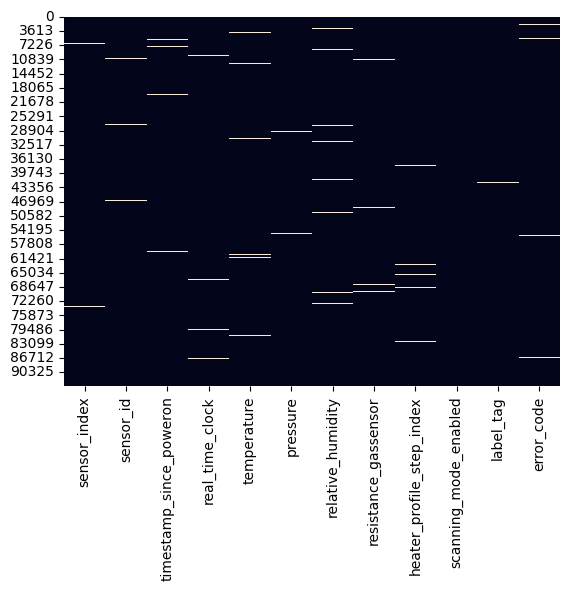

In [24]:
sns.heatmap(ds.isnull(), cbar=False)

<Axes: >

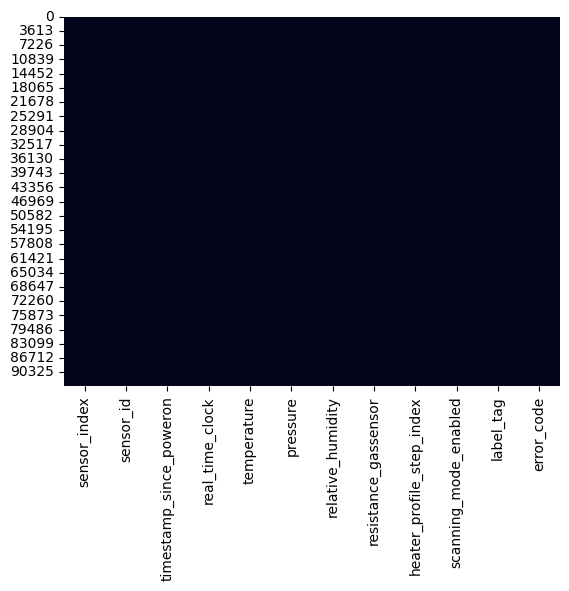

In [25]:
sns.heatmap(na_0206.isnull(), cbar=False)

### 3. List

In [26]:
_list = [na_0206, na_2806, na_2807, cf_0206, cf_2906, cf_2807, cf_3007, fcf_2106, fcf_22_2606, fcf_2807]

In [27]:
# @title
# Define a function to map the heater_profile_step_index values to target_temp
def map_target_temp(heater_index):
    if heater_index in [0, 7, 8, 9]:
        return 320
    elif heater_index in [1, 2, 3]:
        return 100
    elif heater_index in [4, 5, 6]:
        return 200

In [28]:
# @title
def convert_HP_to_temp(df):
  # Create the new "target_temp" column using the map function
  df['target_temp'] = df['heater_profile_step_index'].map(map_target_temp)

  # # Drop the "heater_profile_step_index" column
  # df.drop(columns=['heater_profile_step_index'], inplace=True)

In [29]:
for ds in _list:
  convert_HP_to_temp(ds)

Check null:

In [30]:
for i in _list:
  print(i.isnull().sum().sum())

0
0
0
0
0
0
0
0
0
0


### 4a. Feature Extraction - Method 1
Take samples of raw data for 10 seconds, perform processing to obtain a data sample.

#### Functions

In [31]:
# @title
# Chia nhỏ thành các tập con theo cấu hình Heater Profile 354
def get_list_of_subsets(ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # subset 1 - 320
  subset_2_indices = [1, 2, 3] # subset 2 - 100
  subset_3_indices = [4, 5, 6] # subset 3 - 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = ds[ds['heater_profile_step_index'].isin(subset_1_indices)]
  subset_2 = ds[ds['heater_profile_step_index'].isin(subset_2_indices)]
  subset_3 = ds[ds['heater_profile_step_index'].isin(subset_3_indices)]

  return [subset_1, subset_2, subset_3]

In [32]:
# @title
# The raw data processing function
# Step 1: Divide into small sets according to sensor_index; Sort data by time
# Step 2: Take each small group of data in a short time window every 10s for processing
# Step 3: For each group, divide into subgroups according to the temperature profile of the sensor.
# Step 4: Merge the data samples in the subgroup into a new data sample, by calculating the mean, maximum, and minimum values

In [33]:
# @title
# Step 1: Divide into small sets according to sensor_index; Sort data by time
def get_list_of_sensor_datasets(ds):
  index = [0,1,2,3,4,5,6,7]
  _list = []
  for ind in index:
    sns_ds = ds[ds['sensor_index'] == ind]
    sns_ds = sns_ds.sort_values(by=["real_time_clock"])
    _list.append(sns_ds)

  return _list

In [34]:
# @title
# Step 2: Take each small group of data in a short time window every 10s for processing
def _10s_process(sensor_ds, label_name):
  # 3D array
  temp_data = []
  temp_labels = []

  # Sort by time
  sensor_ds = sensor_ds.sort_values(by=["real_time_clock"])

  # Step 1: Convert "time" column to datetime format (if not already in datetime)
  # Convert "unix_time" column to datetime format
  sensor_ds['real_time_clock'] = pd.to_datetime(sensor_ds['real_time_clock'], unit='s')

  # Step 2: Group the data based on 10-second intervals
  interval_seconds = 10
  grouped_ds = sensor_ds.groupby(pd.Grouper(key='real_time_clock', freq=f'{interval_seconds}S', origin='start'))

  # Step 3: Process each group accordingly
  for group_name, group_data in grouped_ds:
    if group_data.shape[0] >=8:
      _2d_element = create_subsets(group_data)
      temp_data.append(_2d_element)
      temp_labels.append(label_name)

  return temp_data, temp_labels

In [35]:
# @title
# Step 3: For each group, divide into subgroups according to the Heater profile of the sensor.
def create_subsets(_10s_ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # 320
  subset_2_indices = [1, 2, 3] # 100
  subset_3_indices = [4, 5, 6] # 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_1_indices)]
  subset_2 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_2_indices)]
  subset_3 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_3_indices)]

  # Convert datetime back to unix_time
  _temp = subset_1['real_time_clock'].copy()
  subset_1['real_time_clock'] = _temp.astype(int) // 10**9

  _temp = subset_2['real_time_clock'].copy()
  subset_2['real_time_clock'] = _temp.astype(int) // 10**9

  _temp = subset_3['real_time_clock'].copy()
  subset_3['real_time_clock'] = _temp.astype(int) // 10**9

  # Create new samples
  sample1 = new_sample(subset_1)
  sample1['HP_config'] = 320
  sample2 = new_sample(subset_2)
  sample2['HP_config'] = 100
  sample3 = new_sample(subset_3)
  sample3['HP_config'] = 200

  # Feature select
  selected_features = ['temperature', 'pressure', 'relative_humidity',
       'resistance_gassensor', 'resistance_min', 'resistance_max', 'HP_config']

  # Create a new series
  n_sample1 = sample1.loc[selected_features]
  n_sample2 = sample2.loc[selected_features]
  n_sample3 = sample3.loc[selected_features]

  # Create a new array
  array1 = np.array(n_sample1.values)
  array2 = np.array(n_sample2.values)
  array3 = np.array(n_sample3.values)

  # Vertically stack the 1D arrays to create a 2D array
  two_dim_array = np.vstack((array1, array2, array3))

  return two_dim_array # numpy 2D array

In [36]:
# @title
# Tạo new sample từ subset dataframe
def new_sample(subset):
  averaged_row = subset.mean(axis=0)

  # Calculate the min and max resistance
  averaged_row.loc['resistance_min'] = subset['resistance_gassensor'].min()
  averaged_row.loc['resistance_max'] = subset['resistance_gassensor'].max()

  return averaged_row # Series

#### Call

In [37]:
# @title
def feature_extraction_with_10s_HP(rds, label_name):
  temp_data = []
  temp_labels = []

  # Step 1: Divide into small sets according to sensor_index; Sort data by time
  sns_list = get_list_of_sensor_datasets(rds)

  # Create a temp dataset
  p_rds = pd.DataFrame()
  processed_sns_ds = pd.DataFrame()

  # For each sensor dataset
  for sns_ds in sns_list:
    # Step 2: Take each small group of data in a short time window every 10s for processing
    _3d_arr, labels = _10s_process(sns_ds, label_name)
    temp_data.append(_3d_arr)
    temp_labels.append(labels)

  _data = np.concatenate(temp_data, axis=0)
  _labels = np.concatenate(temp_labels)

  return _data, _labels

In [38]:
pd.options.mode.chained_assignment = None

na11_data, na11_label = feature_extraction_with_10s_HP(na_0206, 0)
na12_data, na12_label = feature_extraction_with_10s_HP(na_2806, 0)
na13_data, na13_label = feature_extraction_with_10s_HP(na_2807, 0)

cf11_data, cf11_label = feature_extraction_with_10s_HP(cf_0206, 1)
cf12_data, cf12_label = feature_extraction_with_10s_HP(cf_2906, 1)
cf13_data, cf13_label = feature_extraction_with_10s_HP(cf_2807, 1)
cf14_data, cf14_label = feature_extraction_with_10s_HP(cf_3007, 1)

fcf11_data, fcf11_label = feature_extraction_with_10s_HP(fcf_2106, 2)
fcf12_data, fcf12_label = feature_extraction_with_10s_HP(fcf_22_2606, 2)
fcf13_data, fcf13_label = feature_extraction_with_10s_HP(fcf_2807, 2)

#### Check null

In [ ]:
def check_nan(df):
  # Check for NaN values in the 3D array
  nan_mask = np.isnan(df)

  # Count the number of NaN values
  num_nan_values = np.sum(nan_mask)
  print(num_nan_values)

In [ ]:
clist = [na11_data, na12_data, na13_data, cf11_data, cf12_data, cf13_data, cf14_data, fcf11_data, fcf12_data, fcf13_data]

In [ ]:
for i in clist:
  check_nan(fcf12_data)

0
0
0
0
0
0


#### Concat

In [ ]:
# @title
def concat_instances_of_smell(_data, _labels):
  smell_data = np.concatenate(_data)
  smell_label = np.concatenate(_labels)

  return smell_data, smell_label

In [ ]:
na_data, na_labels = concat_instances_of_smell([na11_data, na12_data, na13_data], [na11_label, na12_label, na13_label])

cf_data, cf_labels = concat_instances_of_smell([cf11_data, cf12_data, cf13_data, cf14_data], [cf11_label, cf12_label, cf13_label, cf14_label])

fcf_data, fcf_labels = concat_instances_of_smell([fcf11_data, fcf12_data, fcf13_data], [fcf11_label, fcf12_label, fcf13_label])

validate

In [ ]:
# @title
# val_na_data, val_na_labels = concat_instances_of_smell([na21_data, na22_data, na23_data], [na21_label, na22_label, na23_label])

# val_cf_data, val_cf_labels = concat_instances_of_smell([cf21_data, cf22_data], [cf21_label, cf22_label])

# val_fcf_data = fcf21_data
# val_fcf_labels = fcf21_label

#### Convert into Tensors

In [ ]:
# @title
def convert_to_tensors(_3d_array):
    _tensors = []

    for element in _3d_array:
        tensor_element = tf.convert_to_tensor(element, dtype=tf.float32)
        _tensors.append(tensor_element)

    return _tensors

In [ ]:
na_tensors_data = convert_to_tensors(na_data)
na_tensors_label = tf.convert_to_tensor(na_labels, dtype=tf.int32)

cf_tensors_data = convert_to_tensors(cf_data)
cf_tensors_label = tf.convert_to_tensor(cf_labels, dtype=tf.int32)

fcf_tensors_data = convert_to_tensors(fcf_data)
fcf_tensors_label = tf.convert_to_tensor(fcf_labels, dtype=tf.int32)

Validate

In [ ]:
# @title
# na_val_tensors_data = convert_to_tensors(val_na_data)
# na_val_tensors_label = tf.convert_to_tensor(val_na_labels, dtype=tf.int32)

# cf_tensors_data = convert_to_tensors(val_cf_data)
# cf_tensors_label = tf.convert_to_tensor(val_cf_labels, dtype=tf.int32)

# fcf_val_tensors_data = convert_to_tensors(val_fcf_data)
# fcf_val_tensors_label = tf.convert_to_tensor(val_fcf_labels, dtype=tf.int32)

#### Concat tensor lists into a dataset

In [ ]:
# Concatenate the data lists vertically
concatenated_data = np.vstack((na_tensors_data, cf_tensors_data, fcf_tensors_data))
# Concatenate the label lists
concatenated_labels = np.concatenate((na_tensors_label, cf_tensors_label, fcf_tensors_label))

Validate

In [ ]:
# @title
val_data = np.vstack((na_val_tensors_data, cf_tensors_data, fcf_val_tensors_data))
val_labels = np.concatenate((na_val_tensors_label, cf_tensors_label, fcf_val_tensors_label))

#### Standardization

In [ ]:
mean = np.mean(concatenated_data, axis=(0, 1), keepdims=True)
std = np.std(concatenated_data, axis=(0, 1), keepdims=True)

In [ ]:
mean

array([[[4.9935837e+01, 1.0018401e+03, 2.0705200e+01, 3.3385760e+07,
         3.1648054e+07, 3.4991364e+07, 2.0706526e+02]]], dtype=float32)

In [ ]:
std

array([[[2.6418126e+00, 4.3573885e+00, 4.0298886e+00, 4.3360788e+07,
         4.2132820e+07, 4.4757552e+07, 8.9909363e+01]]], dtype=float32)

In [ ]:
standardized_data = (concatenated_data - mean) / std

In [ ]:
standardized_val = (val_data - mean) / std

#### Shuffle

In [ ]:
num_samples = standardized_data.shape[0]
indices = np.random.permutation(num_samples)

In [ ]:
shuffled_concatenated_data = standardized_data[indices]
shuffled_concatenated_labels = concatenated_labels[indices]

#### Split into Train/Test/Validate sets

In [ ]:
# @title
def split(_x, _y):
  # Define the proportions for train, test, and validation sets
  train_proportion = 0.8
  test_proportion = 0.1
  validation_proportion = 0.1

  # Calculate the number of samples for each set
  num_samples = _x.shape[0]
  num_train_samples = int(num_samples * train_proportion)
  num_test_samples = int(num_samples * test_proportion)
  num_validation_samples = num_samples - num_train_samples - num_test_samples

  # Split the data and labels into train, test, and validation sets
  x_train = _x[:num_train_samples]
  y_train = _y[:num_train_samples]

  x_test = _x[num_train_samples:num_train_samples + num_test_samples]
  y_test = _y[num_train_samples:num_train_samples + num_test_samples]

  x_val = _x[num_train_samples + num_test_samples:]
  y_val = _y[num_train_samples + num_test_samples:]

  return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = split(shuffled_concatenated_data, shuffled_concatenated_labels)

#### PCA implementation

In [ ]:
ds = x_train
ds_y = y_train

In [ ]:
dim0, dim1 = ds.shape[0], ds.shape[1] * ds.shape[2]

In [ ]:
# Reshape the array into a 2D array
dim0, dim1 = x_train.shape[0], x_train.shape[1] * x_train.shape[2]
x_train_pca = tf.reshape(x_train, [dim0, dim1])

dim0, dim1 = x_test.shape[0], x_test.shape[1] * x_test.shape[2]
x_test_pca = tf.reshape(x_test, [dim0, dim1])

dim0, dim1 = x_val.shape[0], x_val.shape[1] * x_val.shape[2]
x_val_pca = tf.reshape(x_val, [dim0, dim1])

# dim0, dim1 = standardized_val.shape[0], standardized_val.shape[1] * standardized_val.shape[2]
# val_pca = tf.reshape(standardized_val, [dim0, dim1])

In [ ]:
from sklearn.decomposition import PCA

# Set the n_components=3
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)
x_val_pca = pca.transform(x_val_pca)
# val_pca = pca.transform(val_pca)

# Check the dimensions of data after PCA
print(x_train_pca.shape)

(259205, 3)


In [ ]:
# Check the values of eigen vectors
# prodeced by principal components
# principal.components_
x = x_train_pca[:1000]
ds_y = y_train[:1000]

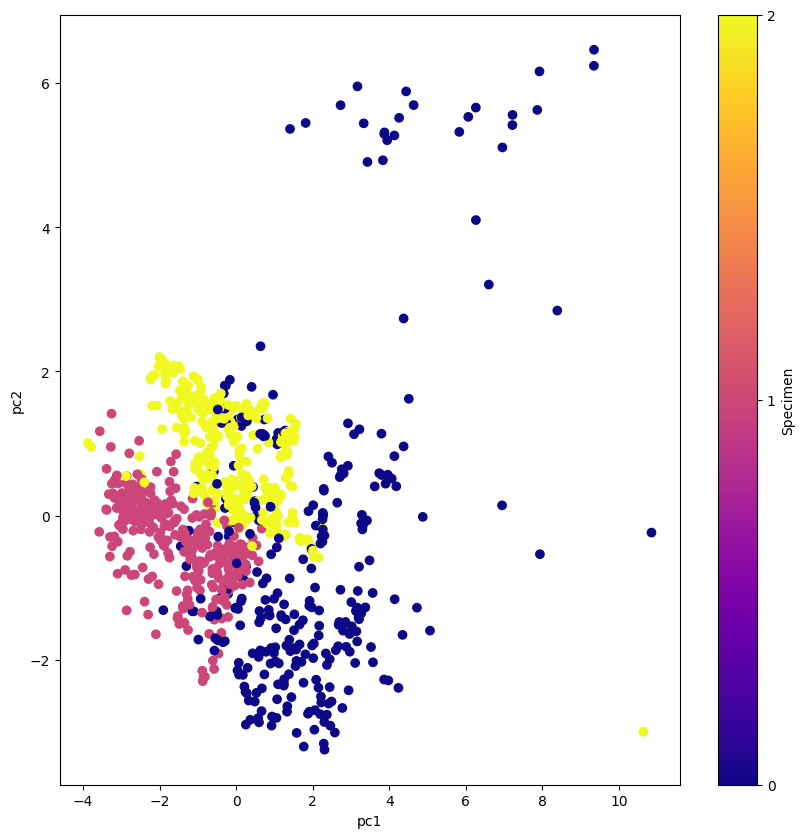

In [ ]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0],x[:,1],c=ds_y,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(ds_y))
cbar.set_label('Specimen')

Text(0.5, 0, 'PC3')

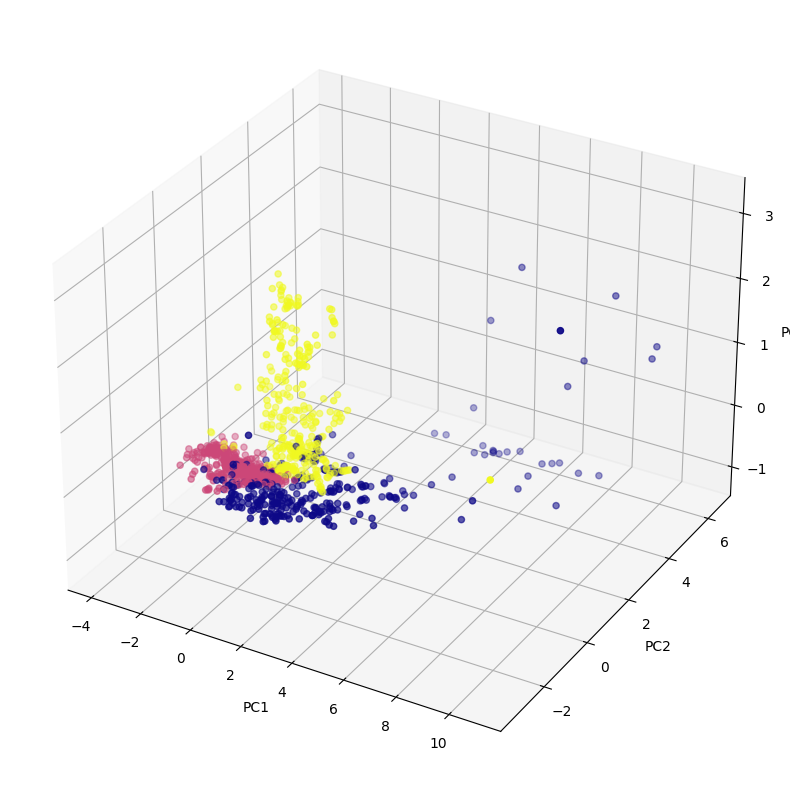

In [ ]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')

# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=ds_y,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)


#### LDA implementation

In [ ]:
ds = x_train
ds_y = y_train

In [ ]:
# Reshape the array into a 2D array
dim0, dim1 = x_train.shape[0], x_train.shape[1] * x_train.shape[2]
x_train_lda = tf.reshape(x_train, [dim0, dim1])

dim0, dim1 = x_test.shape[0], x_test.shape[1] * x_test.shape[2]
x_test_lda = tf.reshape(x_test, [dim0, dim1])

dim0, dim1 = x_val.shape[0], x_val.shape[1] * x_val.shape[2]
x_val_lda = tf.reshape(x_val, [dim0, dim1])

# dim0, dim1 = standardized_val.shape[0], standardized_val.shape[1] * standardized_val.shape[2]
# val_lda = tf.reshape(standardized_val, [dim0, dim1])

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# initializing the model with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
# fitting the dataset
x_train_lda = lda.fit(x_train_lda, ds_y).transform(x_train_lda)
x_test_lda = lda.transform(x_test_lda)
x_val_lda = lda.transform(x_val_lda)
# val_lda = lda.transform(val_lda)

In [ ]:
x = x_train_lda
ds_y = y_train

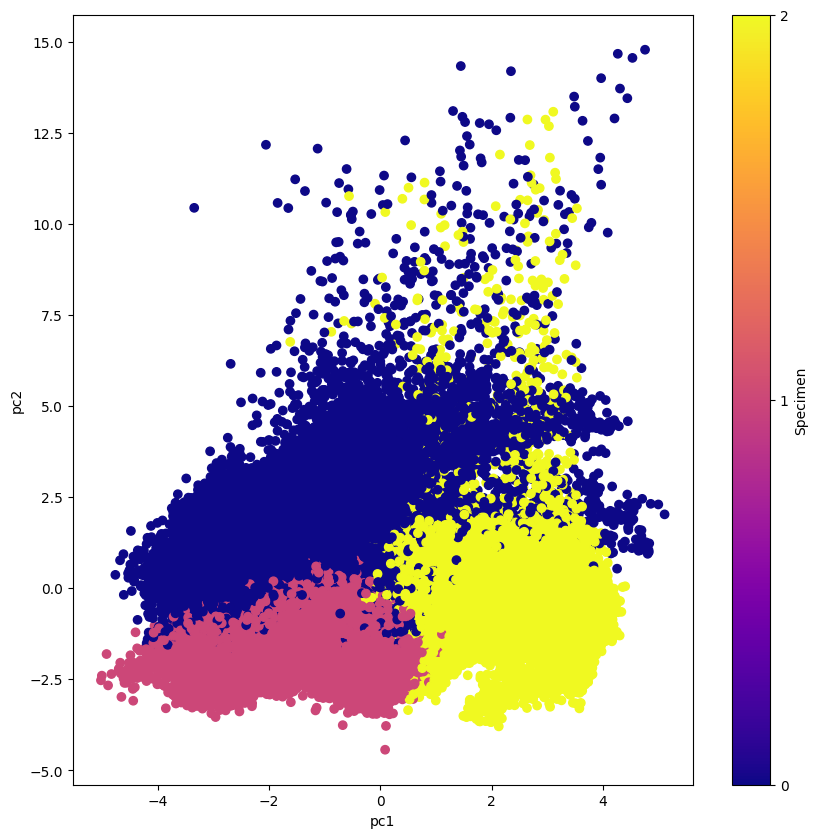

In [ ]:
# plot size
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0],x[:,1],c=ds_y,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(ds_y))
cbar.set_label('Specimen')

#### Train

In [ ]:
# Assuming each data point is a 2D array of shape (3, num_features)
num_features = 7
input_shape = (3,7)
num_classes = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Flatten())  # Flatten the 2D array to a 1D array
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # num_classes is 10 in this case (0 to 9)


Compile

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
              metrics=['accuracy'])


Train

In [ ]:
# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

# Train the model
num_epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, epochs=num_epochs, callbacks=callbacks, batch_size=batch_size, validation_data=(standardized_val, val_labels))

Epoch 1/50
5721/5721 [==============================] - 20s 3ms/step - loss: 0.0497 - accuracy: 0.9822 - val_loss: 0.1384 - val_accuracy: 0.9530
Epoch 2/50
5721/5721 [==============================] - 15s 3ms/step - loss: 0.0186 - accuracy: 0.9926 - val_loss: 0.0553 - val_accuracy: 0.9771
Epoch 3/50
5721/5721 [==============================] - 16s 3ms/step - loss: 0.0147 - accuracy: 0.9943 - val_loss: 0.0434 - val_accuracy: 0.9834
Epoch 4/50
5721/5721 [==============================] - 15s 3ms/step - loss: 0.0122 - accuracy: 0.9952 - val_loss: 0.0892 - val_accuracy: 0.9771
Epoch 5/50
5721/5721 [==============================] - 15s 3ms/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.0654 - val_accuracy: 0.9805


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 21)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               2816      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 11,267
Trainable params: 11,267
Non-trainable params: 0
_________________________________________________________________


#### Evalute

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

1013/1013 [==============================] - 2s 2ms/step - loss: 0.0103 - accuracy: 0.9959
Test accuracy: 0.99586421251297


In [ ]:
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=1)

print('Validate accuracy:', val_acc * 100.0)

1013/1013 [==============================] - 2s 2ms/step - loss: 0.0115 - accuracy: 0.9956
Validate accuracy: 99.55866932868958


In [ ]:
val_loss, val_acc = model.evaluate(standardized_val, val_labels, verbose=1)

print('Validate accuracy:', val_acc * 100.0)

1996/1996 [==============================] - 3s 2ms/step - loss: 0.0654 - accuracy: 0.9805
Validate accuracy: 98.0514407157898


#### Other evaluation parameters

In [ ]:
# Make predictions on test data
y_pred = model.predict(standardized_val)

1996/1996 [==============================] - 3s 1ms/step


**A logit tensor:**

In [ ]:
preds= tf.math.argmax(y_pred, axis=1, output_type=tf.int64)
preds = preds.numpy()
preds

array([0, 0, 0, ..., 2, 2, 2])

Calculate the F1 score, recall and confusion matrix:

In [ ]:
y_true = val_labels

Accuracy: 0.9805143949124401
Recall: 0.9812076480101503
Precision: 0.9804521198826922
F1 Score: 0.9807345208590035
Confusion Matrix:
[[22836   573     1]
 [   99 18664    29]
 [  527    15 21098]]


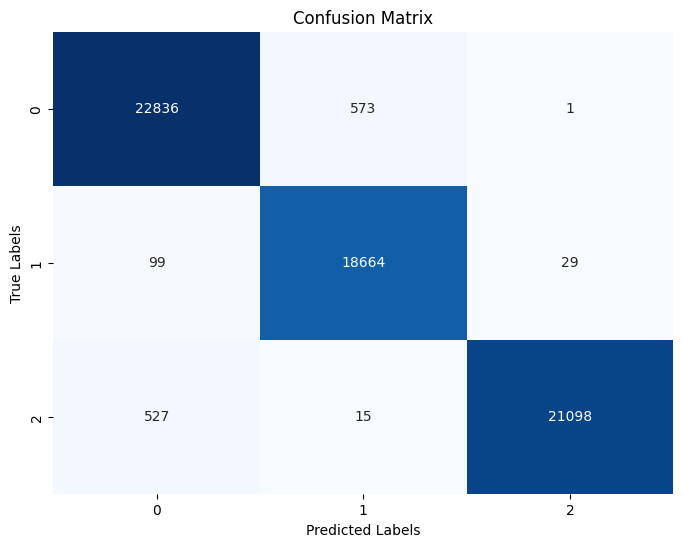

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

accuracy = accuracy_score(y_true, preds)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_true, preds, average='macro')
print("Recall:", recall)

precision = precision_score(y_true, preds, average='macro')
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(y_true, preds, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, preds)
print("Confusion Matrix:")
print(cm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### 4b. Feature Selection - Method 2

In [ ]:
# List of columns to keep
desired_columns = [
    'sensor_index', 'real_time_clock', 'temperature', 'pressure',
    'relative_humidity', 'resistance_gassensor', 'target_temp'
]
# Select only the desired columns
_na_0206 = na_0206[desired_columns]
_na_2806 = na_2806[desired_columns]
_cf_0206 = cf_0206[desired_columns]
_cf_2906 = cf_2906[desired_columns]
_fcf_2106 = fcf_2106[desired_columns]
_fcf_22_2606 = fcf_22_2606[desired_columns]

all_ds = pd.concat([_na_kit_0206, _na_kit_2806, _cf_kit_0206, _cf_kit_2906, _fcf_kit_2106, _fcf_kit_22_2606], axis=0)

#### Standardization

In [ ]:
# @title
from sklearn.preprocessing import StandardScaler

def manual_standard(df, all_ds):
  # Assuming scent_df is your DataFrame containing scent data with 10 columns
  # and 'column1' and 'column2' are the columns you want to standardize

  columns_to_standardize = ['temperature', 'pressure', 'relative_humidity', 'resistance_gassensor', 'target_temp']

  # Create a new DataFrame with only the columns you want to standardize
  data_to_standardize = df[columns_to_standardize]
  _all_ds = all_ds[columns_to_standardize]

  # Initialize the StandardScaler
  scaler = StandardScaler()
  scaler.fit(_all_ds)

  # Fit and transform the selected columns using the StandardScaler
  standardized_data = scaler.transform(data_to_standardize)

  # Create a DataFrame with the standardized data
  standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)

  # Concatenate the standardized columns with the remaining columns from the original DataFrame
  # You may need to specify the axis (0 for rows, 1 for columns) based on your requirement
  # For example, axis=1 will concatenate horizontally (column-wise)
  result_df = pd.concat([df.drop(columns=columns_to_standardize), standardized_df], axis=1)

  return result_df

In [ ]:
# @title
# Step 1: Divide into small sets according to sensor_index; Sort data by time
def get_list_of_sensor_datasets(ds):
  index = [0,1,2,3,4,5,6,7]
  _list = []
  for ind in index:
    sns_ds = ds[ds['sensor_index'] == ind]
    sns_ds = sns_ds.sort_values(by=["real_time_clock"])
    _list.append(sns_ds)

  return _list

In [ ]:
# @title
# Assuming smell_df is your 2D DataFrame containing the smell data
# Reshape the DataFrame into a 3D array and associate smell labels
def convert_to_3d_array(dataframe, label_name, tensor_size=10):
  desired_columns = [
      'temperature', 'pressure',
    'relative_humidity', 'resistance_gassensor', 'target_temp'
  ]

  # Select only the desired columns
  dataframe = dataframe[desired_columns]

  num_rows, num_features = dataframe.shape
  num_tensors = num_rows // tensor_size

  # Truncate the data to have an even multiple of group_size
  dataframe = dataframe.iloc[:num_tensors * tensor_size, :]

  # Reshape the data into a 3D array
  data_array = dataframe.values.reshape(num_tensors, tensor_size, num_features)

  # Convert scent_labels to a NumPy array
  labels = np.ones(num_tensors) * label_name

  return data_array, labels

In [ ]:
# @title
def convert_to_tensor_array(df, label_name, all_ds=all_ds):
  temp_data = []
  temp_labels = []

  stand_df = manual_standard(df, all_ds)

  sns_list = get_list_of_sensor_datasets(stand_df)

  for sns_ds in sns_list:
    data, labels = convert_to_3d_array(sns_ds, label_name)
    temp_data.append(data)
    temp_labels.append(labels)

  _data = np.concatenate(temp_data, axis=0)
  _labels = np.concatenate(temp_labels)

  return _data, _labels

#### Group features

In [ ]:
# @title
def concat_instances_of_smell(_data, _labels):
  smell_data = np.concatenate(_data)
  smell_label = np.concatenate(_labels)

  return smell_data, smell_label

In [ ]:
_kit_list = [_na_kit_0206, _na_kit_2806, _cf_kit_0206, _cf_kit_2906, _fcf_kit_2106, _fcf_kit_22_2606]

In [ ]:
na_data1, na_labels1 = convert_to_tensor_array(_na_kit_0206, 0)
na_data2, na_labels2 = convert_to_tensor_array(_na_kit_2806, 0)

cf_data1, cf_labels1 = convert_to_tensor_array(_cf_kit_0206, 1)
cf_data2, cf_labels2 = convert_to_tensor_array(_cf_kit_2906, 1)

fcf_data1, fcf_labels1 = convert_to_tensor_array(_fcf_kit_2106, 2)
fcf_data2, fcf_labels2 = convert_to_tensor_array(_fcf_kit_22_2606, 2)

In [ ]:
na_data, na_labels = concat_instances_of_smell([na_data1, na_data2], [na_labels1, na_labels2])

cf_data, cf_labels = concat_instances_of_smell([cf_data1, cf_data2], [cf_labels1, cf_labels2])

fcf_data, fcf_labels = concat_instances_of_smell([fcf_data1, fcf_data2], [fcf_labels1,fcf_labels2])

Validate

In [ ]:
na_val_data1, na_val_labels1 = convert_to_tensor_array(_na_val, 0)

fcf_val_data1, fcf_val_labels1 = convert_to_tensor_array(_fcf_val, 2)

#### Convert into Tensors

In [ ]:
# @title
def convert_to_tensors(_3d_array):
    _tensors = []

    for element in _3d_array:
        tensor_element = tf.convert_to_tensor(element, dtype=tf.float32)
        _tensors.append(tensor_element)

    return _tensors

In [ ]:
na_tensors_data = convert_to_tensors(na_data)
na_tensors_label = tf.convert_to_tensor(na_labels, dtype=tf.int32)

cf_tensors_data = convert_to_tensors(cf_data)
cf_tensors_label = tf.convert_to_tensor(cf_labels, dtype=tf.int32)

fcf_tensors_data = convert_to_tensors(fcf_data)
fcf_tensors_label = tf.convert_to_tensor(fcf_labels, dtype=tf.int32)

Validate

In [ ]:
na_val_tensors_data = convert_to_tensors(na_val_data1)
na_val_tensors_label = tf.convert_to_tensor(na_val_labels1, dtype=tf.int32)

fcf_val_tensors_data = convert_to_tensors(fcf_val_data1)
fcf_val_tensors_label = tf.convert_to_tensor(fcf_val_labels1, dtype=tf.int32)

#### Concat tensor lists

In [ ]:
# Concatenate the data lists vertically
concatenated_data = np.vstack((na_tensors_data, cf_tensors_data, fcf_tensors_data))
# Concatenate the label lists
concatenated_labels = np.concatenate((na_tensors_label, cf_tensors_label, fcf_tensors_label))

Validate

In [ ]:
val_data = np.vstack((na_val_tensors_data, fcf_val_tensors_data))
val_labels = np.concatenate((na_val_tensors_label, fcf_val_tensors_label))

#### Shuffle

In [ ]:
num_samples = concatenated_data.shape[0]
indices = np.random.permutation(num_samples)

In [ ]:
shuffled_concatenated_data = concatenated_data[indices]
shuffled_concatenated_labels = concatenated_labels[indices]

Split into Train/Test/Validate sets

In [ ]:
# @title
def split(_x, _y):
  # Define the proportions for train, test, and validation sets
  train_proportion = 0.8
  test_proportion = 0.1
  validation_proportion = 0.1

  # Calculate the number of samples for each set
  num_samples = _x.shape[0]
  num_train_samples = int(num_samples * train_proportion)
  num_test_samples = int(num_samples * test_proportion)
  num_validation_samples = num_samples - num_train_samples - num_test_samples

  # Split the data and labels into train, test, and validation sets
  x_train = _x[:num_train_samples]
  y_train = _y[:num_train_samples]

  x_test = _x[num_train_samples:num_train_samples + num_test_samples]
  y_test = _y[num_train_samples:num_train_samples + num_test_samples]

  x_val = _x[num_train_samples + num_test_samples:]
  y_val = _y[num_train_samples + num_test_samples:]

  return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = split(shuffled_concatenated_data, shuffled_concatenated_labels)

#### PCA implementation

In [ ]:
dim0, dim1 = shuffled_concatenated_data.shape[0], shuffled_concatenated_data.shape[1]*shuffled_concatenated_data.shape[2]

In [ ]:
# Reshape the array into a 2D array
features_scaled = tf.reshape(shuffled_concatenated_data, [dim0, dim1])

In [ ]:
from sklearn.decomposition import PCA

# Set the n_components=3
principal = PCA(n_components=3)
principal.fit(features_scaled)
x=principal.transform(features_scaled)

# Check the dimensions of data after PCA
print(x.shape)

(257635, 3)


In [ ]:
# Check the values of eigen vectors
# prodeced by principal components
# principal.components_

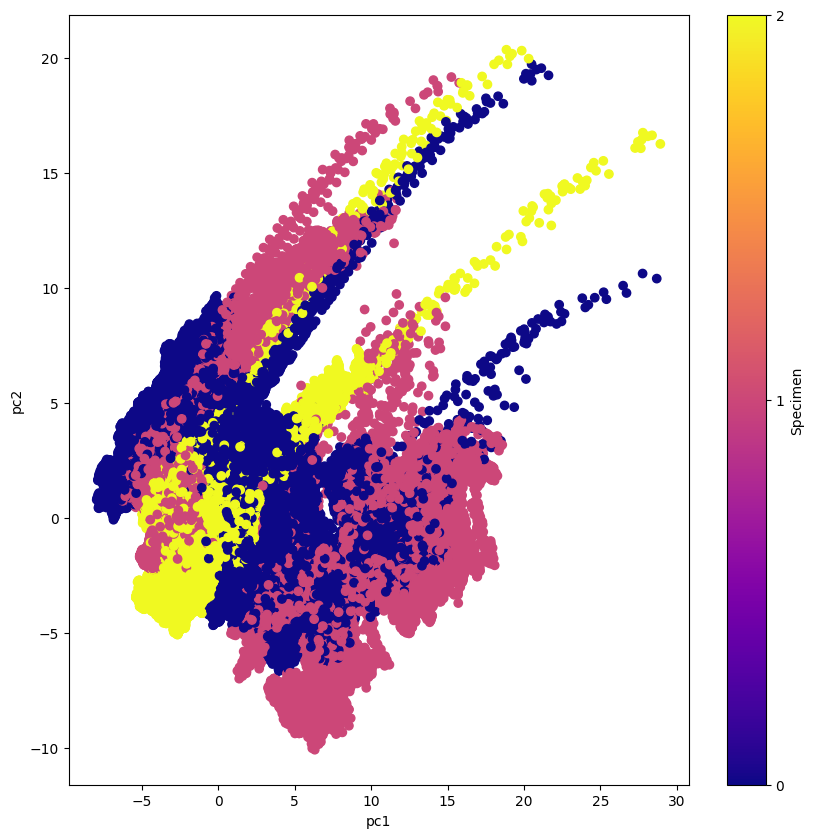

In [ ]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0],x[:,1],c=shuffled_concatenated_labels,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(shuffled_concatenated_labels))
cbar.set_label('Specimen')

Text(0.5, 0, 'PC3')

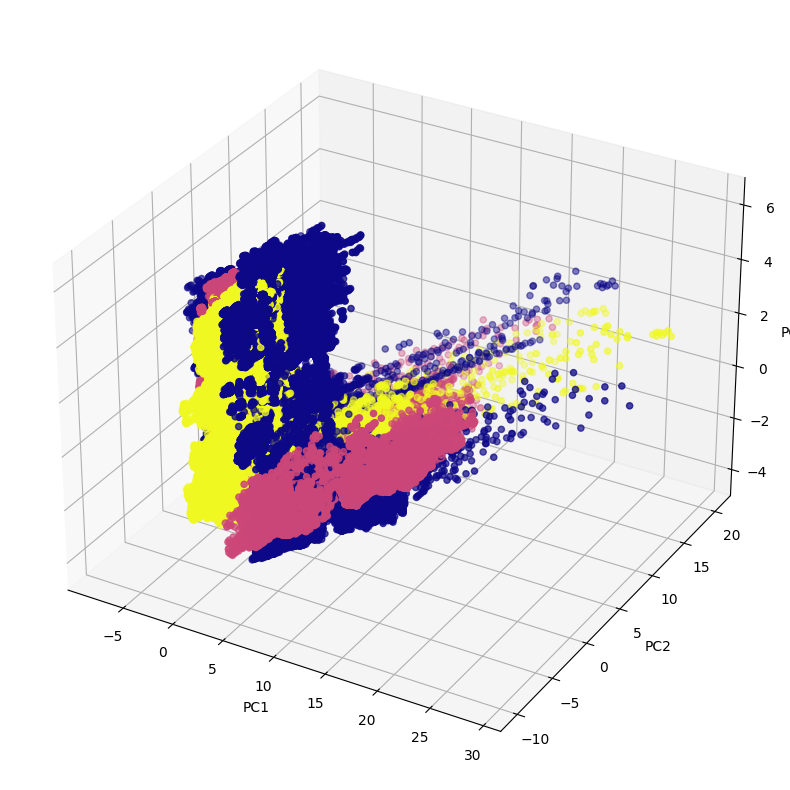

In [ ]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')

# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=shuffled_concatenated_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)


#### LDA implementation

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# initializing the model with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
# fitting the dataset
X_r2 = lda.fit(features_scaled, shuffled_concatenated_labels).transform(features_scaled)

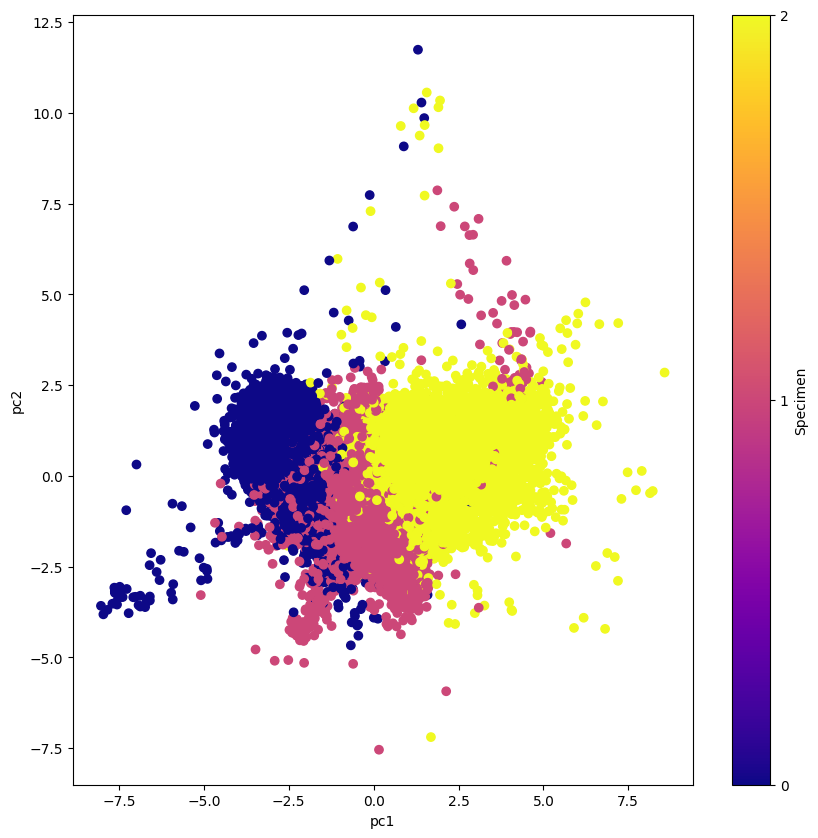

In [ ]:
# plot size
plt.figure(figsize=(10,10))
scatter = plt.scatter(X_r2[:,0],X_r2[:,1],c=shuffled_concatenated_labels,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(shuffled_concatenated_labels))
cbar.set_label('Specimen')

In [ ]:
feat_lda = pd.DataFrame(X_r2, columns=['feature1','feature2'])

In [ ]:
feat_lda.shape

(18000, 2)

In [ ]:
x_val_lda = lda.transform(x_val)

#### Train

In [ ]:
# Assuming each data point is a 2D array of shape (10, num_features)
num_features = 5
input_shape = (10, num_features)
num_classes = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.Flatten())  # Flatten the 2D array to a 1D array
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # num_classes is 10 in this case (0 to 9)


Compile

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
              metrics=['accuracy'])


Train

In [ ]:
# Train the model
num_epochs = 30
batch_size = 32
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(val_data, val_labels))

Epoch 1/30
829/829 [==============================] - 5s 4ms/step - loss: 289167.5000 - accuracy: 0.7866 - val_loss: 3.3875 - val_accuracy: 0.2113
Epoch 2/30
829/829 [==============================] - 3s 4ms/step - loss: 103246.9062 - accuracy: 0.8757 - val_loss: 5.6562 - val_accuracy: 0.3486
Epoch 3/30
829/829 [==============================] - 3s 3ms/step - loss: 67492.8984 - accuracy: 0.9038 - val_loss: 7.6960 - val_accuracy: 0.3754
Epoch 4/30
829/829 [==============================] - 3s 3ms/step - loss: 52743.4062 - accuracy: 0.9165 - val_loss: 9.3062 - val_accuracy: 0.3996
Epoch 5/30
829/829 [==============================] - 3s 3ms/step - loss: 38616.7070 - accuracy: 0.9273 - val_loss: 10.5112 - val_accuracy: 0.3981
Epoch 6/30
829/829 [==============================] - 6s 7ms/step - loss: 34530.2578 - accuracy: 0.9268 - val_loss: 11.2914 - val_accuracy: 0.3850
Epoch 7/30
829/829 [==============================] - 3s 3ms/step - loss: 17728.0488 - accuracy: 0.9418 - val_loss: 11.6

#### Evalute

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

104/104 [==============================] - 0s 1ms/step - loss: 0.7886 - accuracy: 0.5400
Test accuracy: 0.539993941783905


In [ ]:
val_loss, val_acc = model.evaluate(val_data, val_labels, verbose=1)

print('Validate accuracy:', val_acc * 100.0)

529/529 [==============================] - 1s 1ms/step - loss: 9.8660 - accuracy: 0.2429
Validate accuracy: 24.286136031150818


#### Other evaluation parameters

In [ ]:
val_labels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
# Make predictions on test data
y_pred = model.predict(val_data)

529/529 [==============================] - 1s 1ms/step


**A logit tensor:**

In [ ]:
preds= tf.math.argmax(y_pred, axis=1, output_type=tf.int64)
preds = preds.numpy()
preds

array([2, 2, 2, ..., 1, 1, 1])

Calculate the F1 score, recall and confusion matrix:

Accuracy: 0.805911912503695
Recall: 0.3635413983654608
Precision: 0.4965233940941438
F1 Score: 0.38270684091015444
Confusion Matrix:
[[13247    26   315]
 [    0     0     0]
 [  852  2090   385]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


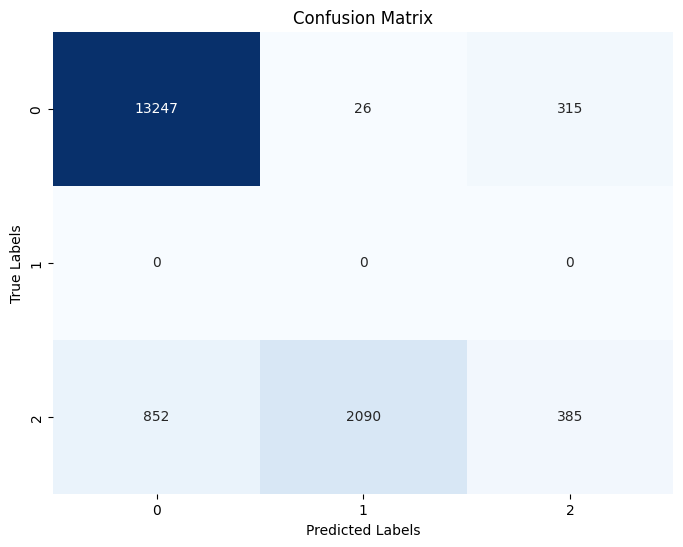

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

accuracy = accuracy_score(val_labels, preds)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(val_labels, preds, average='macro')
print("Recall:", recall)

precision = precision_score(val_labels, preds, average='macro')
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(val_labels, preds, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(val_labels, preds)
print("Confusion Matrix:")
print(cm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Data cleaning

Check null:

In [ ]:
for i in phone_list:
  print(i.isnull().sum().sum())
for i in kit_list:
  print(i.isnull().sum().sum())
for i in kit_val:
  print(i.isnull().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0


Data cleaning from phone

In [ ]:
# @title
na_phone_2707['status'] = na_phone_2707['status'].apply(int, base=16)
na_phone_2807['status'] = na_phone_2807['status'].apply(int, base=16)

cf_phone_2707['status'] = cf_phone_2707['status'].apply(int, base=16)
fcf_phone_2707['status'] = fcf_phone_2707['status'].apply(int, base=16)

In [ ]:
# @title
na_phone_2707.shape

(5872, 8)

In [ ]:
# @title
na_phone_2807.shape

(31397, 8)

In [ ]:
# @title
cf_phone_2707.shape

(93863, 8)

In [ ]:
# @title
fcf_phone_2707.shape

(146730, 8)

In [ ]:
# @title
res_na_phone_2707 = na_phone_2707[na_phone_2707['status'] == 176]
res_na_phone_2807 = na_phone_2807[na_phone_2807['status'] == 176]

res_cf_phone_2707 = cf_phone_2707[cf_phone_2707['status'] == 176]
res_fcf_phone_2707 = fcf_phone_2707[fcf_phone_2707['status'] == 176]

In [ ]:
# @title
res_phone_list = [res_na_phone_2707, res_na_phone_2807, res_cf_phone_2707, res_fcf_phone_2707]

In [ ]:
# @title
# na_0206_s0 = na_0206[na_0206['sensor_index'] == 0]

### Data overview
The input is the dataset to be visualized. Here can be: **normal air**, **caffee beans**, **food caffee**.

Visualize per-sensor datasets with defined Heater Profile configuration. Chia nhỏ dataset: RAW dataset => sub-dataset [with sensor] => sub-set [with HP index]

#### Kit

Please choose a RAW dataset


In [ ]:
ds = na_kit_0206

Please choose a sensor index. Default = 0.


In [ ]:
# @title
sensor_index = 0
sns_ds = ds[ds['sensor_index'] == sensor_index]

Please choose a Heater profile index

In [ ]:
# firstA, firstB = next(iter(df_grouped))

In [ ]:
# @title
# hp_index = 0
# hp_ds = sns_ds[sns_ds['heater_profile_step_index'] == hp_index]

##### Visualize: Parameter over time. [1 smell / 1 sensor]

In [ ]:
df = sns_ds

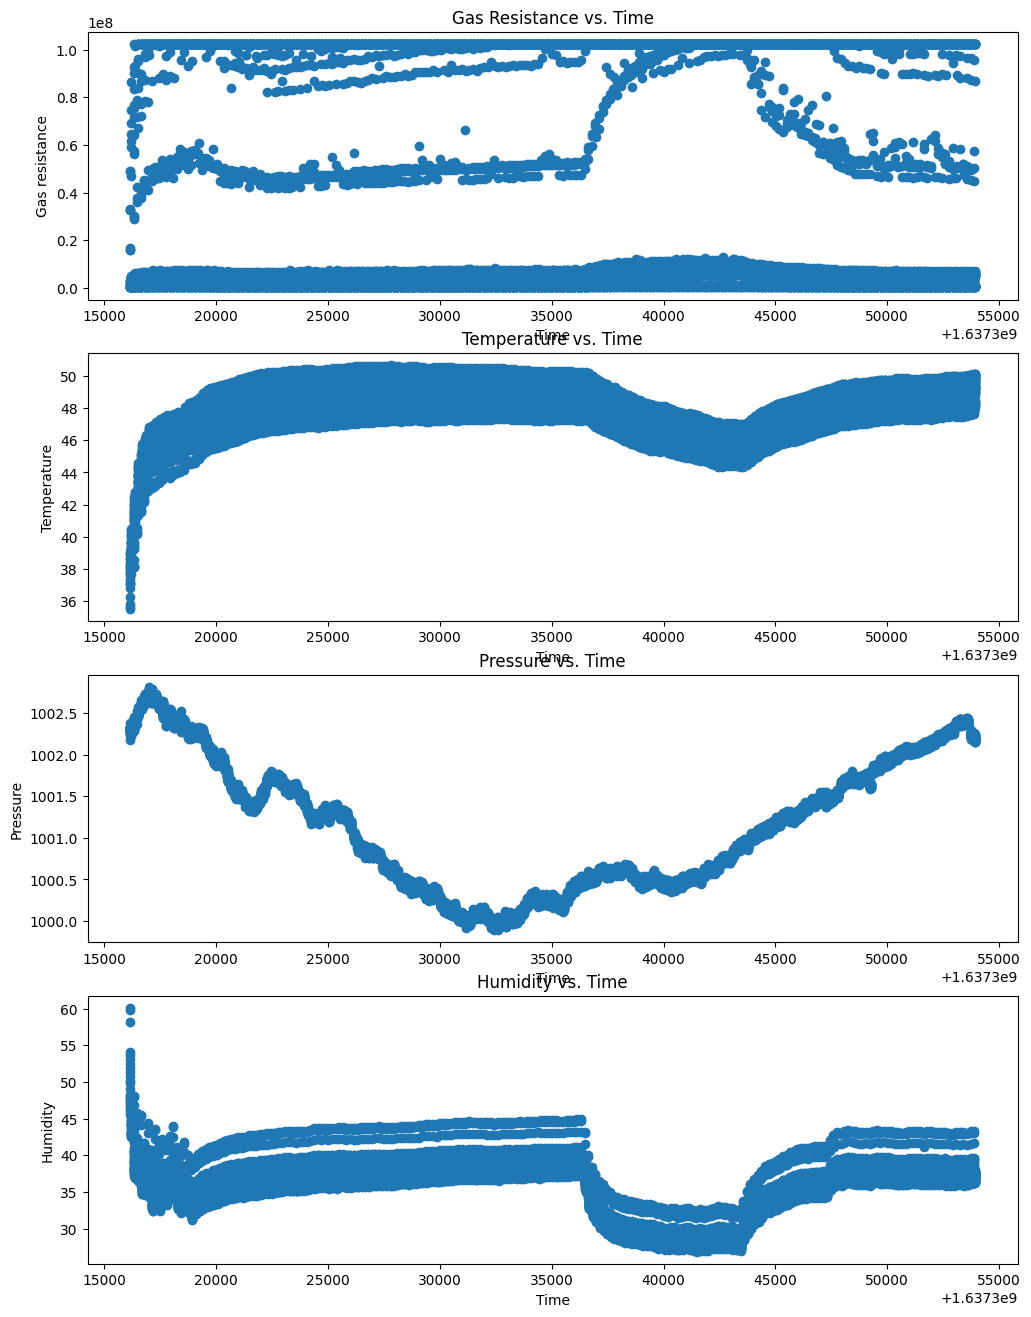

In [ ]:
# @title
fig, ax = plt.subplots(4,1,figsize=(12,16))
# Create the scatter plot
ax[0].scatter(df["real_time_clock"], df["resistance_gassensor"], label="Gas")
# Set labels and title
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Gas resistance")
ax[0].set_title("Gas Resistance vs. Time")

# Create the scatter plot
ax[1].scatter(df["real_time_clock"], df["temperature"], label="Gas")
# Set labels and title
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Temperature")
ax[1].set_title("Temperature vs. Time")

# Create the scatter plot
ax[2].scatter(df["real_time_clock"], df["pressure"], label="Gas")
# Set labels and title
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Pressure")
ax[2].set_title("Pressure vs. Time")

# Create the scatter plot
ax[3].scatter(df["real_time_clock"], df["relative_humidity"], label="Gas")
# Set labels and title
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Humidity")
ax[3].set_title("Humidity vs. Time")

# Show the plot
plt.show()

##### Visualize: The gas resistance distribution with HP-354 [3smell / 1sensor]
Xác định phân phối giá trị trở kháng của từng mùi.

In [ ]:
# phone_list = [na_phone_2707, cf_phone_2707, fcf_phone_2707]
# res_phone_list = [res_na_phone_2707, res_cf_phone_2707, res_fcf_phone_2707]

kit_list = [na_kit_0206, na_kit_2806, cf_kit_0206, cf_kit_2906, fcf_kit_2106, fcf_kit_22_2606]

In [ ]:
na = pd.concat([na_kit_0206, na_kit_2806], axis=0)
cf = pd.concat([cf_kit_0206, cf_kit_2906], axis=0)
fcf = pd.concat([fcf_kit_2106, fcf_kit_22_2606], axis=0)

In [ ]:
sns_na = na[na['sensor_index'] == 1]
sns_cf = cf[cf['sensor_index'] == 1]
sns_fcf = fcf[fcf['sensor_index'] == 1]

sns_na_val = na_val[na_val['sensor_index'] == 1]
sns_fcf_val = fcf_val[fcf_val['sensor_index'] == 1]

Function: get_list_of_subsets(ds)

In [ ]:
# @title
# Chia nhỏ thành các tập con theo cấu hình Heater Profile 354
def get_list_of_subsets(ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # subset 1 - 320
  subset_2_indices = [1, 2, 3] # subset 2 - 100
  subset_3_indices = [4, 5, 6] # subset 3 - 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = ds[ds['heater_profile_step_index'].isin(subset_1_indices)]
  subset_2 = ds[ds['heater_profile_step_index'].isin(subset_2_indices)]
  subset_3 = ds[ds['heater_profile_step_index'].isin(subset_3_indices)]

  return [subset_1, subset_2, subset_3]

In [ ]:
# @title
na_list = get_list_of_subsets(sns_na)
cf_list = get_list_of_subsets(sns_cf)
fcf_list = get_list_of_subsets(sns_fcf)

na_val_list = get_list_of_subsets(sns_na_val)
fcf_val_list = get_list_of_subsets(sns_fcf_val)

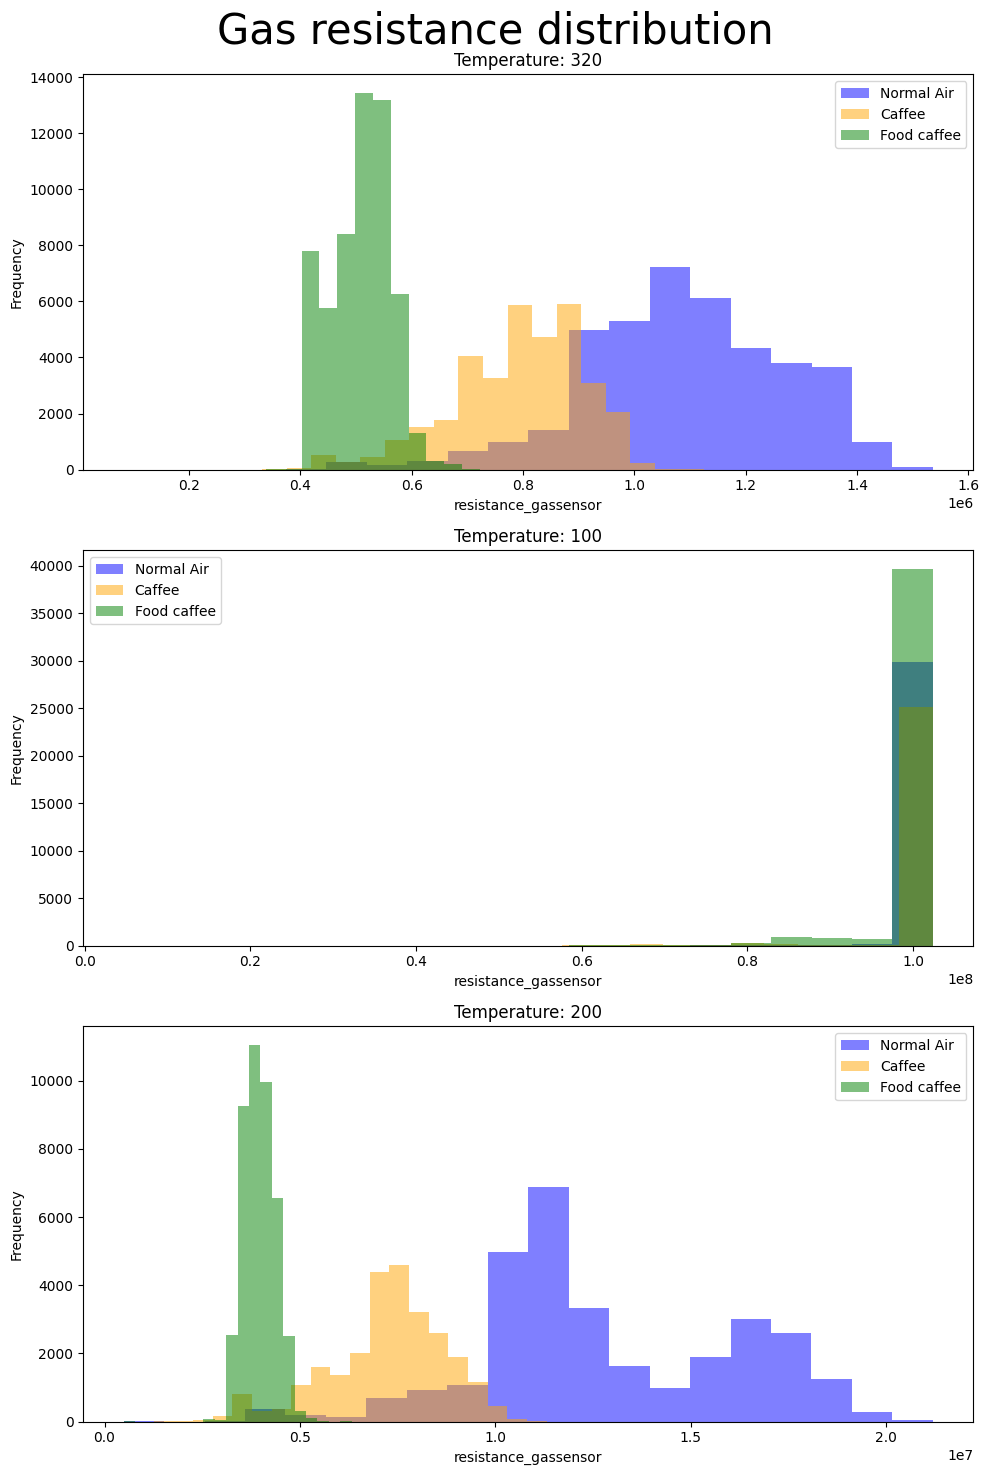

In [ ]:
# @title
# Function to create histograms
# Temperature profiles
temperatures = [320, 100, 200]

def plot_histograms(scent_data_1, scent_data_2, scent_data_3, scent_data_4, scent_data_5):
    plt.figure(figsize=(10, 15))
    plt.suptitle('Gas resistance distribution', fontsize=30)

    for i, (df1, df2, df3, df4, df5) in enumerate(zip(scent_data_1, scent_data_2, scent_data_3, scent_data_4, scent_data_5)):
        plt.subplot(3, 1, i+1)
        plt.hist(df1['resistance_gassensor'], bins=20, alpha=0.5, label='Normal Air', color='blue')
        plt.hist(df2['resistance_gassensor'], bins=20, alpha=0.5, label='Caffee', color='orange')
        plt.hist(df3['resistance_gassensor'], bins=20, alpha=0.5, label='Food caffee', color='green')
        # plt.hist(df4['resistance_gassensor'], bins=20, alpha=0.5, label='Normal Air val', color='red')
        # plt.hist(df5['resistance_gassensor'], bins=20, alpha=0.5, label='Food caffee val', color='black')

        plt.xlabel('resistance_gassensor')  # Replace 'column_name' and 'X-axis Label' with your actual column and label
        plt.ylabel('Frequency')
        plt.title(f'Temperature: {temperatures[i]}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot histograms for both scents
plot_histograms(na_list, cf_list, fcf_list, na_val_list, fcf_val_list)

##### Visualize: Probability parameters of gas resistance in the Heater Profile 354 configuration for each odor

In [ ]:
# @title
# Step 1: Combine the three DataFrames into a dictionary
datasets = {
    "Coffee": cf_kit_0206,
    "Air": na_kit_0206,
    "Food Coffee": fcf_kit_22_2606
}

In [ ]:
# @title
# Step 2: Create subsets and calculate statistics
result = {}

for smell, df in datasets.items():
    # Break down the DataFrame into subsets based on 'heater_profile_step_index' groups
    group_0_7_8_9 = df[df['heater_profile_step_index'].isin([0, 7, 8, 9])]
    group_1_2_3 = df[df['heater_profile_step_index'].isin([1, 2, 3])]
    group_4_5_6 = df[df['heater_profile_step_index'].isin([4, 5, 6])]

    # Calculate the mean, maximum, and minimum values of 'resistance_gassensor' for each subset
    stats = {
        'group_0_7_8_9': group_0_7_8_9['resistance_gassensor'].agg(['mean', 'max', 'min']),
        'group_1_2_3': group_1_2_3['resistance_gassensor'].agg(['mean', 'max', 'min']),
        'group_4_5_6': group_4_5_6['resistance_gassensor'].agg(['mean', 'max', 'min'])
    }

    # Store the statistics in the result dictionary
    result[smell] = stats

In [ ]:
# @title
# Step 4: Visualize the results
fig, ax = plt.subplots(3,1,figsize=(8, 16))

x_labels = ['Group 0/7/8/9', 'Group 1/2/3', 'Group 4/5/6']
x = range(len(x_labels))

na_x = [0,0,0,1,1,1,2,2,2]
na_ = [result["Air"]['group_0_7_8_9']['mean'], result["Air"]['group_0_7_8_9']['max'], result["Air"]['group_0_7_8_9']['min'],
          result["Air"]['group_1_2_3']['mean'], result["Air"]['group_1_2_3']['max'], result["Air"]['group_1_2_3']['min'],
          result["Air"]['group_4_5_6']['mean'], result["Air"]['group_4_5_6']['max'], result["Air"]['group_4_5_6']['min'],
          ]
ax.plot(na_x, na_, 'ob', label='Air')

cf_x = [0,0,0,1,1,1,2,2,2]
cf_ = [result["Coffee"]['group_0_7_8_9']['mean'], result["Coffee"]['group_0_7_8_9']['max'], result["Coffee"]['group_0_7_8_9']['min'],
          result["Coffee"]['group_1_2_3']['mean'], result["Coffee"]['group_1_2_3']['max'], result["Coffee"]['group_1_2_3']['min'],
          result["Coffee"]['group_4_5_6']['mean'], result["Coffee"]['group_4_5_6']['max'], result["Coffee"]['group_4_5_6']['min'],
          ]
ax.plot(cf_x, cf_, 'or', label='Coffee')

fcf_x = [0,0,0,1,1,1,2,2,2]
fcf_ = [result["Food Coffee"]['group_0_7_8_9']['mean'], result["Food Coffee"]['group_0_7_8_9']['max'], result["Food Coffee"]['group_0_7_8_9']['min'],
          result["Food Coffee"]['group_1_2_3']['mean'], result["Food Coffee"]['group_1_2_3']['max'], result["Food Coffee"]['group_1_2_3']['min'],
          result["Food Coffee"]['group_4_5_6']['mean'], result["Food Coffee"]['group_4_5_6']['max'], result["Food Coffee"]['group_4_5_6']['min'],
          ]
ax.plot(fcf_x, fcf_, 'oy', label='Food Coffee')

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Heater Profile Step Index')
ax.set_ylabel('Resistance Gas Sensor')
ax.legend()
ax.set_title('Resistance Gas Sensor for Different Smells')

plt.tight_layout()
plt.show()

##### Visualize: Gas Resistance according to Time  

In [ ]:
# @title
# Function: Visualize a HP step on a figure and axis
def visualize_one_HPstep(hp_dataset, fig, ax):
  ax.plot(hp_dataset["timestamp_since_poweron"], hp_dataset["resistance_gassensor"], label="HP {}".format(hp_dataset["heater_profile_step_index"].unique()),marker='o', markersize=5)
  # Set the labels and title
  ax.set_xlabel("Time [s]")
  ax.set_ylabel("Resistance_gassensor [Ohm]")
  ax.set_title("Time vs. Resistance_gassensor")

  ax.legend()

# Function: Visualize a dataset with options:
# Args:
# 1. RAW dataset
# 2. sensor_index: define a sensor on Board x8
# 3. hp_index: define the HP step of the above sensor
# 4. short: full or partial?
def visualize_the_dataset(dataset, sensor_index = 0, hp_index = 0, fig=None, ax=None, short=True):
  sns_ind = [0,1,2,3,4,5,6,7]
  hp_ind = [0,1,2,3,4,5,6,7,8,9]

  if fig is None or ax is None:
    # Create a figure
    fig, ax = plt.subplots(figsize=(12,6))

  if sensor_index not in sns_ind:
    pass
  else:
    # With one sensor_index
    sns_ds = dataset[dataset['sensor_index'] == sensor_index]

  if hp_index not in hp_ind:
    if hp_index == -1:
      # Visualize the all HP steps
      for index in sns_ds['heater_profile_step_index'].unique():
        hp_ds = sns_ds[sns_ds['heater_profile_step_index'] == index]
        # Short dataset
        if short:
          hp_ds = hp_ds.iloc[:20]
        hp_ds = hp_ds.sort_values(by=["timestamp_since_poweron"])
        visualize_one_HPstep(hp_ds, fig, ax)
  else:
    # With one HP index
    hp_ds = sns_ds[sns_ds['heater_profile_step_index'] == hp_index]
    # Short dataset
    if short:
      hp_ds = hp_ds.iloc[:50]

    visualize_one_HPstep(hp_ds, fig, ax)

In [ ]:
# @title
# fig, ax = plt.subplots(figsize=(12,6))

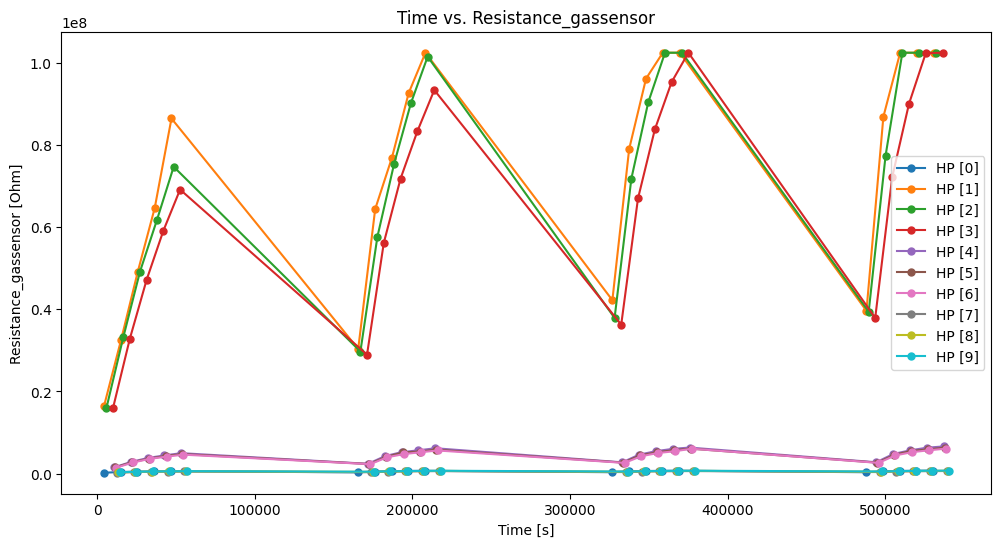

In [ ]:
visualize_the_dataset(df, 0, -1)

#### Phone

In [ ]:
# @title
phone_list = [na_phone_2707, na_phone_2807, cf_phone_2707, fcf_phone_2707]
res_phone_list = [res_na_phone_2707, res_na_phone_2807, res_cf_phone_2707, res_fcf_phone_2707]

kit_list = [na_kit_0206, na_kit_2806, cf_kit_0206, cf_kit_2906, fcf_kit_2106, fcf_kit_22_2606]

##### Visualize: Parameter over time. [1 smell / 1 sensor]

In [ ]:
df = na_phone_2807

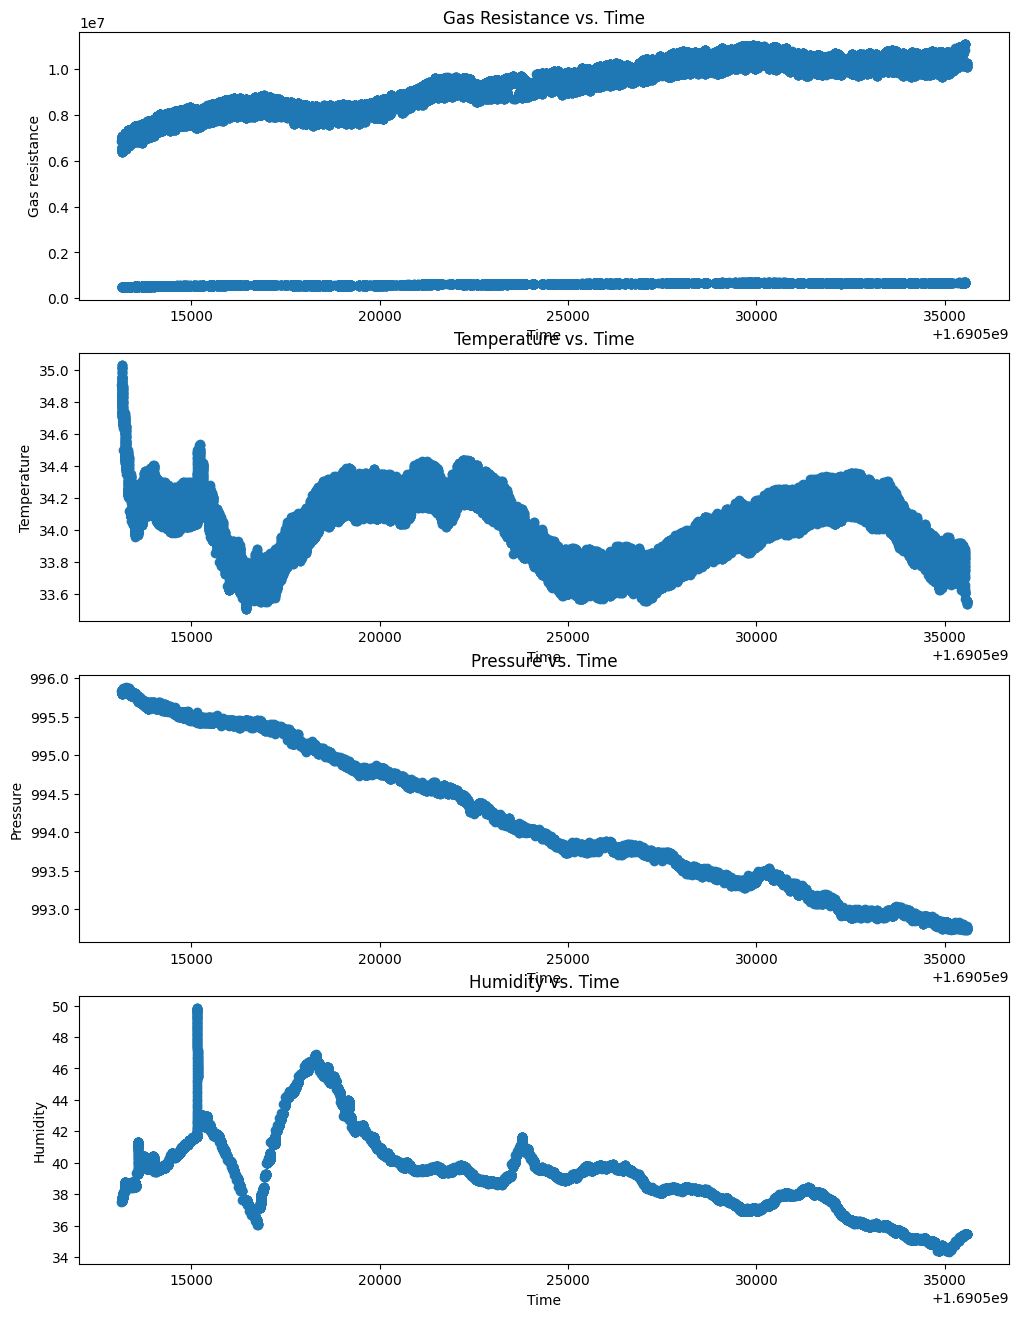

In [ ]:
# @title
fig, ax = plt.subplots(4,1,figsize=(12,16))
# Create the scatter plot
ax[0].scatter(df["unix_time"], df["resistance_gassensor"], label="Gas")
# Set labels and title
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Gas resistance")
ax[0].set_title("Gas Resistance vs. Time")

# Create the scatter plot
ax[1].scatter(df["unix_time"], df["temperature"], label="Gas")
# Set labels and title
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Temperature")
ax[1].set_title("Temperature vs. Time")

# Create the scatter plot
ax[2].scatter(df["unix_time"], df["pressure"], label="Gas")
# Set labels and title
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Pressure")
ax[2].set_title("Pressure vs. Time")

# Create the scatter plot
ax[3].scatter(df["unix_time"], df["relative_humidity"], label="Gas")
# Set labels and title
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Humidity")
ax[3].set_title("Humidity vs. Time")

# Show the plot
plt.show()

##### Visualize: The gas resistance distribution with HP-354 [3smell / 1sensor]
Xác định phân phối giá trị trở kháng của từng mùi.

In [ ]:
res_phone_list = [res_na_phone_2707, res_na_phone_2807, res_cf_phone_2707, res_fcf_phone_2707]

In [ ]:
na_ = pd.concat([res_na_phone_2707, res_na_phone_2807], axis=0)
cf_ = res_cf_phone_2707
fcf_ = res_fcf_phone_2707

In [ ]:
na_.shape

(5081, 8)

Function: get_list_of_subsets(ds)

In [ ]:
# @title
# Chia nhỏ thành các tập con theo cấu hình Heater Profile 354
def get_list_of_subsets_phone(ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # subset 1 - 320
  subset_2_indices = [1, 2, 3] # subset 2 - 100
  subset_3_indices = [4, 5, 6] # subset 3 - 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = ds[ds['hp_index'].isin(subset_1_indices)]
  subset_2 = ds[ds['hp_index'].isin(subset_2_indices)]
  subset_3 = ds[ds['hp_index'].isin(subset_3_indices)]

  return [subset_1, subset_2, subset_3]

In [ ]:
# @title
na_p_list = get_list_of_subsets_phone(na_)
cf_p_list = get_list_of_subsets_phone(cf_)
fcf_p_list = get_list_of_subsets_phone(fcf_)

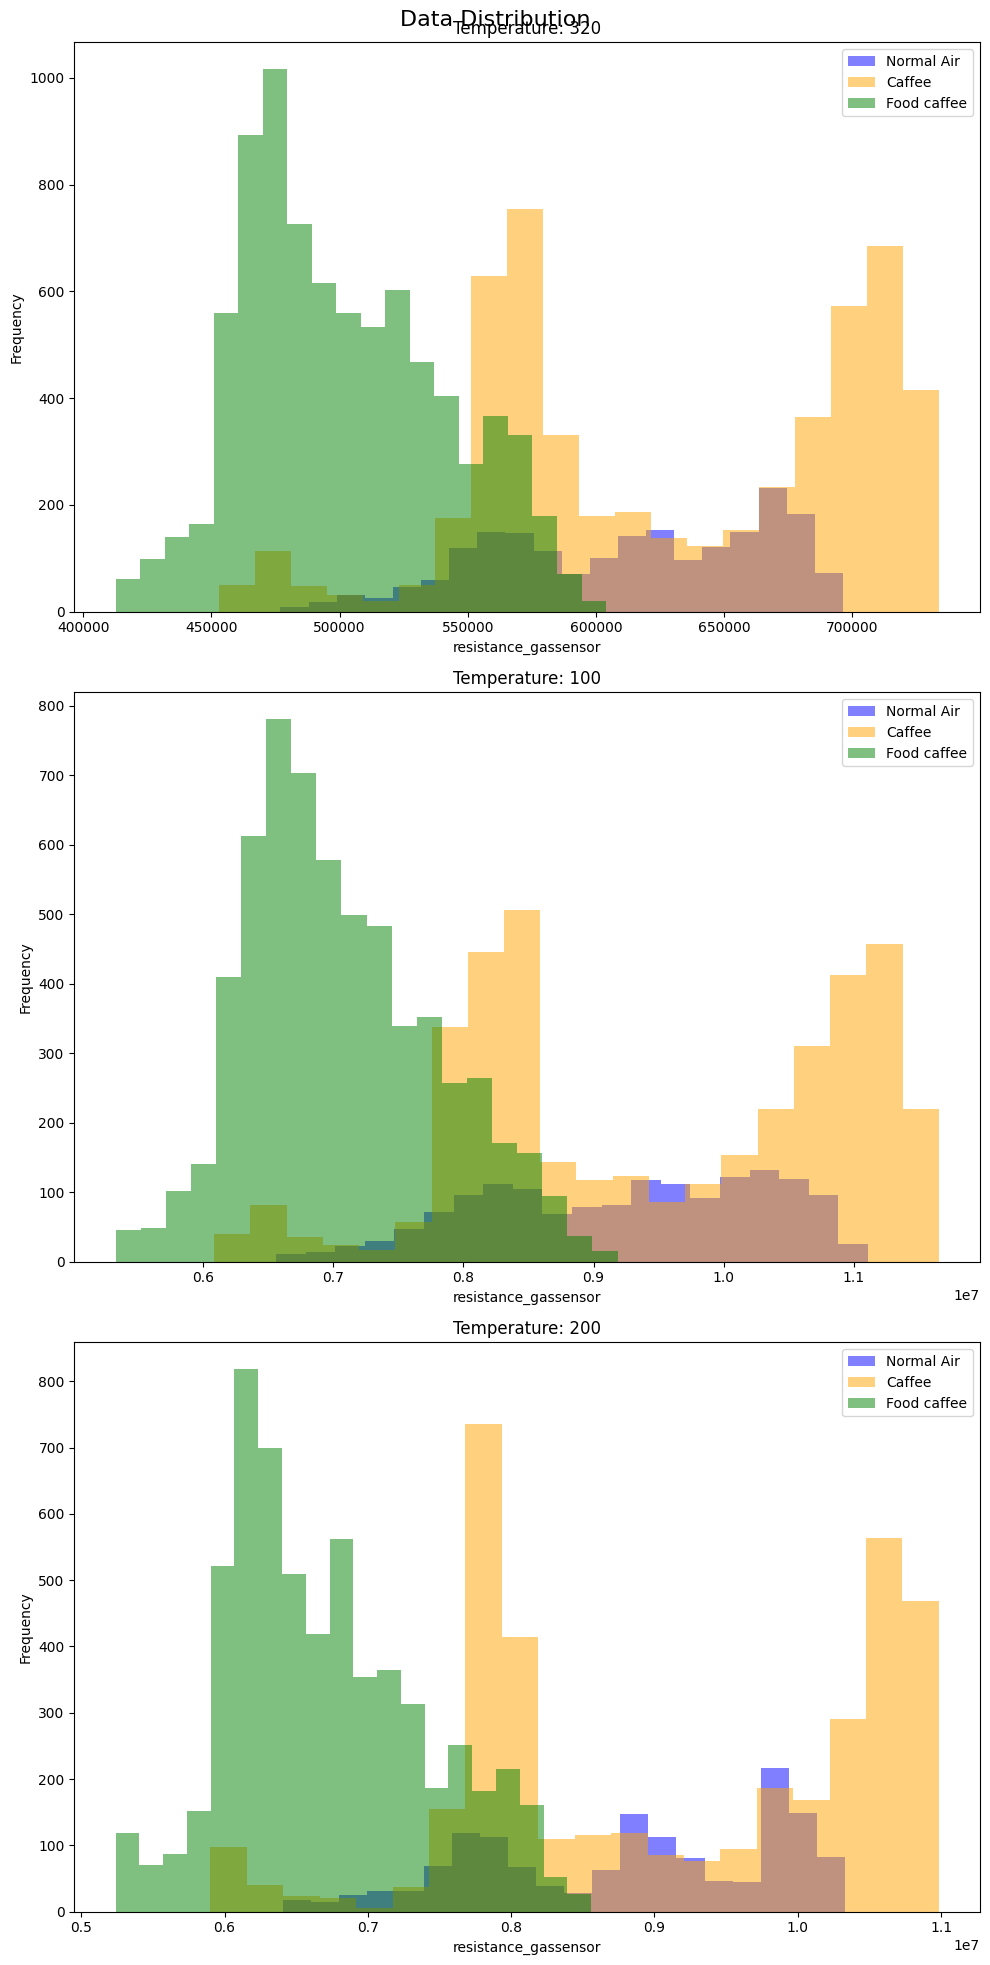

In [ ]:
# @title
# Function to create histograms
# Temperature profiles
temperatures = [320, 100, 200]

def plot_histograms(scent_data_1, scent_data_2, scent_data_3):
    plt.figure(figsize=(10, 20))
    plt.suptitle('Data Distribution', fontsize=16)

    for i, (df1, df2, df3) in enumerate(zip(scent_data_1, scent_data_2, scent_data_3)):
        plt.subplot(3, 1, i+1)
        plt.hist(df1['resistance_gassensor'], bins=20, alpha=0.5, label='Normal Air', color='blue')
        plt.hist(df2['resistance_gassensor'], bins=20, alpha=0.5, label='Caffee', color='orange')
        plt.hist(df3['resistance_gassensor'], bins=20, alpha=0.5, label='Food caffee', color='green')
        plt.xlabel('resistance_gassensor')  # Replace 'column_name' and 'X-axis Label' with your actual column and label
        plt.ylabel('Frequency')
        plt.title(f'Temperature: {temperatures[i]}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Plot histograms for both scents
plot_histograms(na_p_list, cf_p_list, fcf_p_list)

### Feature extraction

Functions

In [ ]:
# @title
# Chia nhỏ thành các tập con theo cấu hình Heater Profile 354
def get_list_of_subsets(ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # subset 1 - 320
  subset_2_indices = [1, 2, 3] # subset 2 - 100
  subset_3_indices = [4, 5, 6] # subset 3 - 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = ds[ds['heater_profile_step_index'].isin(subset_1_indices)]
  subset_2 = ds[ds['heater_profile_step_index'].isin(subset_2_indices)]
  subset_3 = ds[ds['heater_profile_step_index'].isin(subset_3_indices)]

  return [subset_1, subset_2, subset_3]

In [ ]:
# @title
# The raw data processing function
# Step 1: Divide into small sets according to sensor_index; Sort data by time
# Step 2: Take each small group of data in a short time window every 10s for processing
# Step 3: For each group, divide into subgroups according to the temperature profile of the sensor.
# Step 4: Merge the data samples in the subgroup into a new data sample, by calculating the mean, maximum, and minimum values

In [ ]:
# @title
# Step 1: Divide into small sets according to sensor_index; Sort data by time
def get_list_of_sensor_datasets(ds):
  index = [0,1,2,3,4,5,6,7]
  _list = []
  for ind in index:
    sns_ds = ds[ds['sensor_index'] == ind]
    sns_ds = sns_ds.sort_values(by=["real_time_clock"])
    _list.append(sns_ds)

  return _list

In [ ]:
# @title
# Step 2: Take each small group of data in a short time window every 10s for processing
def _10s_process(sensor_ds):
  # Create a new dataframe
  # new_ds = pd.DataFrame()
  processed_sns = pd.DataFrame()

  # Sort by time
  sensor_ds = sensor_ds.sort_values(by=["real_time_clock"])

  # Step 1: Convert "time" column to datetime format (if not already in datetime)
  # Convert "unix_time" column to datetime format
  sensor_ds['real_time_clock'] = pd.to_datetime(sensor_ds['real_time_clock'], unit='s')

  # Step 2: Group the data based on 10-second intervals
  interval_seconds = 10
  grouped_ds = sensor_ds.groupby(pd.Grouper(key='real_time_clock', freq=f'{interval_seconds}S', origin='start'))

  # Step 3: Process each group accordingly
  for group_name, group_data in grouped_ds:
    series_list = create_subsets(group_data)
    for row in series_list:
      # Add the Series as a new row to the DataFrame using append()
      processed_sns = processed_sns.append(row, ignore_index=True)

  # new_ds = pd.concat([new_ds, processed_group], axis=0)
  # new_ds.columns = processed_group.columns

  return processed_sns

In [ ]:
# @title
# Step 3: For each group, divide into subgroups according to the Heater profile of the sensor.
def create_subsets(_10s_ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # 320
  subset_2_indices = [1, 2, 3] # 100
  subset_3_indices = [4, 5, 6] # 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_1_indices)]
  subset_2 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_2_indices)]
  subset_3 = _10s_ds[_10s_ds['heater_profile_step_index'].isin(subset_3_indices)]

  # Convert datetime back to unix_time
  subset_1['real_time_clock'] = subset_1['real_time_clock'].astype(int) // 10**9
  subset_2['real_time_clock'] = subset_2['real_time_clock'].astype(int) // 10**9
  subset_3['real_time_clock'] = subset_3['real_time_clock'].astype(int) // 10**9

  # Create new samples
  sample1 = new_sample(subset_1)
  sample1['HP_config'] = 320
  sample2 = new_sample(subset_2)
  sample2['HP_config'] = 100
  sample3 = new_sample(subset_3)
  sample3['HP_config'] = 200

  # # Add the column names
  # column_names = sample1.columns

  # # Create a new dataframe
  # new_df = pd.DataFrame(columns=column_names)

  # # Concat dataframes
  # new_df = pd.concat([sample1, sample2, sample3], axis=0)

  return [sample1, sample2, sample3] # List of series

In [ ]:
# @title
# Tạo new sample từ subset dataframe
def new_sample(subset):
  # # Add the column names
  # column_names = pd.Index(list(subset.columns) + ["resistance_min"] + ["resistance_max"])

  # # Create a new dataframe
  # new_df = pd.DataFrame(columns=column_names)

  # Calculate the average of each column
  averaged_row = subset.mean(axis=0)

  # Calculate the min and max resistance
  averaged_row.loc['resistance_min'] = subset['resistance_gassensor'].min()
  averaged_row.loc['resistance_max'] = subset['resistance_gassensor'].max()

  # # Append the averaged row to the new dataframe
  # new_df = new_df.append(averaged_row, ignore_index=True)

  return averaged_row # Series

#### Feature selection

Kit

In [ ]:
# @title
phone_list = [na_phone_2707, na_phone_2807, cf_phone_2707, fcf_phone_2707]
res_phone_list = [res_na_phone_2707, res_na_phone_2807, res_cf_phone_2707, res_fcf_phone_2707]

kit_list = [na_kit_0206, na_kit_2806, cf_kit_0206, cf_kit_2906, fcf_kit_2106, fcf_kit_22_2606]

In [ ]:
# List of columns to keep
desired_columns = [
    'sensor_index', 'real_time_clock', 'temperature', 'pressure',
    'relative_humidity', 'resistance_gassensor', 'heater_profile_step_index'
]

# Select only the desired columns
na_kit_0206 = na_kit_0206[desired_columns]
na_kit_2806 = na_kit_2806[desired_columns]
cf_kit_0206 = cf_kit_0206[desired_columns]
cf_kit_2906 = cf_kit_2906[desired_columns]
fcf_kit_2106 = fcf_kit_2106[desired_columns]
fcf_kit_22_2606 = fcf_kit_22_2606[desired_columns]

na_val = na_val[desired_columns]
fcf_val = fcf_val[desired_columns]

Phone

In [ ]:
# @title
res_na_phone_2707 = res_na_phone_2707.iloc[:,:6]
res_na_phone_2807 = res_na_phone_2807.iloc[:,:6]
res_cf_phone_2707 = res_cf_phone_2707.iloc[:,:6]
res_fcf_phone_2707 = res_fcf_phone_2707.iloc[:,:6]

In [ ]:
# @title
# Step 3: For each group, divide into subgroups according to the Heater profile of the sensor.
def create_subsets_phone(_10s_ds):
  # Define the subsets based on "Heater profile index" values
  subset_1_indices = [0, 7, 8, 9] # 320
  subset_2_indices = [1, 2, 3] # 100
  subset_3_indices = [4, 5, 6] # 200

  # Step 2: Create subgroups based on "Heater profile index"
  subset_1 = _10s_ds[_10s_ds['hp_index'].isin(subset_1_indices)]
  subset_2 = _10s_ds[_10s_ds['hp_index'].isin(subset_2_indices)]
  subset_3 = _10s_ds[_10s_ds['hp_index'].isin(subset_3_indices)]

  # Convert datetime back to unix_time
  subset_1['unix_time'] = subset_1['unix_time'].astype(int) // 10**9
  subset_2['unix_time'] = subset_2['unix_time'].astype(int) // 10**9
  subset_3['unix_time'] = subset_3['unix_time'].astype(int) // 10**9

  # Create new samples
  sample1 = new_sample(subset_1)
  sample1['HP_config'] = 320
  sample2 = new_sample(subset_2)
  sample2['HP_config'] = 100
  sample3 = new_sample(subset_3)
  sample3['HP_config'] = 200

  # # Add the column names
  # column_names = sample1.columns

  # # Create a new dataframe
  # new_df = pd.DataFrame(columns=column_names)

  # # Concat dataframes
  # new_df = pd.concat([sample1, sample2, sample3], axis=0)

  return [sample1, sample2, sample3] # List of series

In [ ]:
# @title
# Step 2: Take each small group of data in a short time window every 10s for processing
def _10s_process_phone(sensor_ds):
  # Create a new dataframe
  # new_ds = pd.DataFrame()
  processed_sns = pd.DataFrame()

  # Sort by time
  sensor_ds = sensor_ds.sort_values(by=["unix_time"])

  # Step 1: Convert "time" column to datetime format (if not already in datetime)
  # Convert "unix_time" column to datetime format
  sensor_ds['unix_time'] = pd.to_datetime(sensor_ds['unix_time'], unit='s')

  # Step 2: Group the data based on 10-second intervals
  interval_seconds = 10
  grouped_ds = sensor_ds.groupby(pd.Grouper(key='unix_time', freq=f'{interval_seconds}S', origin='start'))

  # Step 3: Process each group accordingly
  for group_name, group_data in grouped_ds:
    series_list = create_subsets_phone(group_data)
    for row in series_list:
      # Add the Series as a new row to the DataFrame using append()
      processed_sns = processed_sns.append(row, ignore_index=True)

  # new_ds = pd.concat([new_ds, processed_group], axis=0)
  # new_ds.columns = processed_group.columns

  return processed_sns

In [ ]:
# @title
p_res_na_phone_2707 = _10s_process_phone(res_na_phone_2707)
p_res_na_phone_2807 = _10s_process_phone(res_na_phone_2807)
p_res_cf_phone_2707 = _10s_process_phone(res_cf_phone_2707)
p_res_fcf_phone_2707 = _10s_process_phone(res_fcf_phone_2707)

In [ ]:
# @title
p_res_na_phone_2707 = p_res_na_phone_2707.dropna()
p_res_na_phone_2707 = p_res_na_phone_2707.reset_index(drop=True)

p_res_na_phone_2807 = p_res_na_phone_2807.dropna()
p_res_na_phone_2807 = p_res_na_phone_2807.reset_index(drop=True)

p_res_cf_phone_2707 = p_res_cf_phone_2707.dropna()
p_res_cf_phone_2707 = p_res_cf_phone_2707.reset_index(drop=True)

p_res_fcf_phone_2707 = p_res_fcf_phone_2707.dropna()
p_res_fcf_phone_2707 = p_res_fcf_phone_2707.reset_index(drop=True)

#### Extraction

In [ ]:
# @title
def feature_extraction_with_10s_HP(rds):
  # Step 1: Divide into small sets according to sensor_index; Sort data by time
  sns_list = get_list_of_sensor_datasets(rds)

  # Create a temp dataset
  p_rds = pd.DataFrame()
  processed_sns_ds = pd.DataFrame()

  # For each sensor dataset
  for sns_ds in sns_list:
    # Step 2: Take each small group of data in a short time window every 10s for processing
    p_sns = _10s_process(sns_ds)
    p_sns = p_sns.dropna()
    p_sns = p_sns.reset_index(drop=True)
    p_rds = pd.concat([p_rds, p_sns], axis=0)

  return p_rds

In [ ]:
p_na_0206 = feature_extraction_with_10s_HP(na_kit_0206)
p_na_2806 = feature_extraction_with_10s_HP(na_kit_2806)
p_cf_0206 = feature_extraction_with_10s_HP(cf_kit_0206)
p_cf_2906 = feature_extraction_with_10s_HP(cf_kit_2906)
p_fcf_2106 = feature_extraction_with_10s_HP(fcf_kit_2106)
p_fcf_22_2606 = feature_extraction_with_10s_HP(fcf_kit_22_2606)

In [ ]:
p_na_val = feature_extraction_with_10s_HP(na_val)
p_fcf_val = feature_extraction_with_10s_HP(fcf_val)

In [ ]:
# raw
# phone_list = [na_phone_2707, cf_phone_2707, fcf_phone_2707]
# res_phone_list = [res_na_phone_2707, res_cf_phone_2707, res_fcf_phone_2707]

kit_list = [na_kit_0206, na_kit_2806, cf_kit_0206, cf_kit_2906, fcf_kit_2106, fcf_kit_22_2606]

# process
val_list = [p_na_val, p_fcf_val]
p_kit_list = [p_na_0206, p_na_2806, p_cf_0206, p_cf_2906, p_fcf_2106, p_fcf_22_2606]
# p_list = [p_res_na_phone_2707, p_res_na_phone_2807, p_res_cf_phone_2707, p_res_fcf_phone_2707]

In [ ]:
for i in kit_list:
  print(i.isnull().sum().sum())
for i in p_kit_list:
  print(i.isnull().sum().sum())
for i in val_list:
  print(i.isnull().sum().sum())

### Data cleaning

#### Missing values

<Axes: >

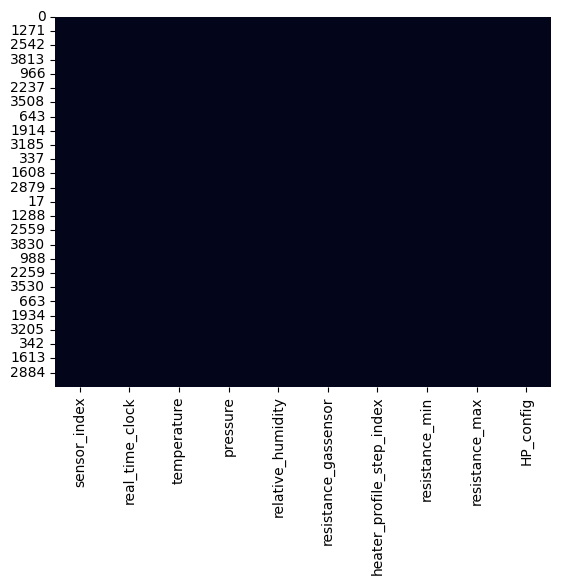

In [ ]:
sns.heatmap(ds.isnull(), cbar=False)

### Data preprocessing

#### Remove the redundant HP steps
The phone runs with the **Force** mode configuration, where the target temperature is 320 and the duration is 150 (ms).

Remove all HP steps with temperature other than 320.



In [ ]:
# @title
def remove_redundant_steps(ds):
  # Redundant steps: 1, 2, 3, 4, 5, 6
  mask = ~ds['heater_profile_step_index'].isin([1, 2, 3, 4, 5, 6])
  new_ds = ds[mask]

  return new_ds

In [ ]:
# @title
# # Remove the redundant HP steps
# nonred_na0 = remove_redundant_steps(na0)
# nonred_na1 = remove_redundant_steps(na1)
# nonred_cf0 = remove_redundant_steps(cf0)
# nonred_cf1 = remove_redundant_steps(cf1)
# nonred_fcf0 = remove_redundant_steps(fcf0)
# nonred_fcf1 = remove_redundant_steps(fcf1)
# nonred_scl0 = remove_redundant_steps(scl0)
# nonred_scl1 = remove_redundant_steps(scl1)
# nonred_scl2 = remove_redundant_steps(scl2)
# nonred_scl3 = remove_redundant_steps(scl3)

#### Process raw gas resistance into resistance average, min and max
From the raw gas resistance data in one step, calculate the resistance average, min and max values with each group of 5 consecutive data samples.

Function

In [ ]:
# @title
def preprocessing_ds(ds):
  # Calculate the number of new rows in the resulting dataframe
  num_new_rows = len(ds) // 5

  # Add the column names
  column_names = pd.Index(list(ds.columns) + ["resistance_min"] + ["resistance_max"])

  # Create a new dataframe
  new_df = pd.DataFrame(columns=column_names)

  # Iterate over the range of new rows
  for i in range(num_new_rows):
    # Get the subset of rows for averaging
    subset = ds.iloc[i * 5: (i + 1) * 5]

    # Calculate the average of each column
    averaged_row = subset.mean(axis=0)

    # Calculate the min and max resistance
    averaged_row.loc['resistance_min'] = subset['resistance_gassensor'].min()
    averaged_row.loc['resistance_max'] = subset['resistance_gassensor'].max()

    # Append the averaged row to the new dataframe
    new_df = new_df.append(averaged_row, ignore_index=True)
  # Re-order columns
  new_df = new_df[['sensor_index', 'sensor_id', 'timestamp_since_poweron',
       'real_time_clock', 'temperature', 'pressure', 'relative_humidity',
       'resistance_gassensor', 'resistance_min', 'resistance_max', 'heater_profile_step_index',
       'scanning_mode_enabled', 'label_tag', 'error_code']]

  return new_df

### New datasets
Create new datasets with above preprocessing from raw dataset

Function

In [ ]:
# @title
def process_the_raw_dataset(ds):
  # Create a new dataset format as dataframe
  new_ds = pd.DataFrame()

  # Iterate over the dataset with sensor_index
  for sensor_index in ds['sensor_index'].unique(): # sensor_index: [0:7]
    sensor_ds = ds[ds['sensor_index'] == sensor_index]

    # Iterate over the sub-dataset with hp_index
    for hp_index in sensor_ds['heater_profile_step_index'].unique(): # hp_index: [0:9]
      hp_ds = sensor_ds[sensor_ds['heater_profile_step_index'] == hp_index]

      # Sort by time
      hp_ds = hp_ds.sort_values(by=["timestamp_since_poweron"])

      # Remove the unstable values
      unstable_num = int(len(hp_ds) * 0.02)
      hp_ds = hp_ds.drop(hp_ds.index[:unstable_num])

      # Extract values: min, max and average gas_res
      processed_hp_ds = preprocessing_ds(hp_ds)

      # Add the processed sub-dataset to the new dataset
      new_ds = pd.concat([new_ds, processed_hp_ds], ignore_index=True)

  return new_ds

Process by function calling

In [ ]:
# @title
# # Extract subsets by HP indexes. Remove unstable data.
# # Create a new data set by concatenating each of the 5 adjacent data samples of the original set,
# # calculating the average, min, max impedance values to generate a new data sample for the new set.
# p_na0 = process_the_raw_dataset(nonred_na0)
# p_na1 = process_the_raw_dataset(nonred_na1)

# p_cf0 = process_the_raw_dataset(nonred_cf0)
# p_cf1 = process_the_raw_dataset(nonred_cf1)

# p_fcf0 = process_the_raw_dataset(nonred_fcf0)
# p_fcf1 = process_the_raw_dataset(nonred_fcf1)

# p_scl0 = process_the_raw_dataset(nonred_scl0)
# p_scl1 = process_the_raw_dataset(nonred_scl1)
# p_scl2 = process_the_raw_dataset(nonred_scl2)
# p_scl3 = process_the_raw_dataset(nonred_scl3)

### Get feature columns of each specimen

In [ ]:
# raw
# phone_list = [na_phone_2707, cf_phone_2707, fcf_phone_2707]
# res_phone_list = [res_na_phone_2707, res_cf_phone_2707, res_fcf_phone_2707]

kit_list = [na_kit_0206, na_kit_2806, cf_kit_0206, cf_kit_2906, fcf_kit_2106, fcf_kit_22_2606]

# process
_list = [p_na_0206, p_na_2806, p_cf_0206, p_cf_2906, p_fcf_2106, p_fcf_22_2606]
p_list = [p_res_na_phone_2707, p_res_na_phone_2807, p_res_cf_phone_2707, p_res_fcf_phone_2707]

In [ ]:
p_na_0206.columns

Index(['sensor_index', 'real_time_clock', 'temperature', 'pressure',
       'relative_humidity', 'resistance_gassensor',
       'heater_profile_step_index', 'resistance_min', 'resistance_max',
       'HP_config'],
      dtype='object')

Kit

In [ ]:
# List of columns to keep
desired_columns = [
'temperature', 'pressure', 'relative_humidity', 'resistance_gassensor', 'resistance_min', 'resistance_max', 'HP_config'
]

# Select only the desired columns
na0_ds = p_na_0206[desired_columns]
na1_ds = p_na_2806[desired_columns]
cf0_ds = p_cf_0206[desired_columns]
cf1_ds = p_cf_2906[desired_columns]
fcf0_ds = p_fcf_2106[desired_columns]
fcf1_ds = p_fcf_22_2606[desired_columns]

In [ ]:
na_val_ds = p_na_val[desired_columns]
fcf_val_ds = p_fcf_val[desired_columns]

In [ ]:
p_na_val.columns

Index(['sensor_index', 'real_time_clock', 'temperature', 'pressure',
       'relative_humidity', 'resistance_gassensor',
       'heater_profile_step_index', 'resistance_min', 'resistance_max',
       'HP_config'],
      dtype='object')

Phone

In [ ]:
# @title
# List of columns to keep
desired_columns = [
'temperature', 'pressure', 'relative_humidity', 'resistance_gassensor', 'resistance_min', 'resistance_max'
]
p_list = [p_res_na_phone_2707, p_res_na_phone_2807, p_res_cf_phone_2707, p_res_fcf_phone_2707]
# Select only the desired columns
na_phone0 = p_res_na_phone_2707[desired_columns]
na_phone1 = p_res_na_phone_2807[desired_columns]
cf_phone0 = p_res_cf_phone_2707[desired_columns]
fcf_phone0 = p_res_fcf_phone_2707[desired_columns]

### Labeling

Gas 1: normal air

In [ ]:
na_specimen = pd.concat([na0_ds, na1_ds], axis=0)
na_specimen['specimen'] = 0

In [ ]:
na_specimen.shape

(266051, 8)

In [ ]:
na_phone = pd.concat([na_phone0, na_phone1], axis=0)
na_phone['specimen'] = 0

In [ ]:
na_phone.shape

(2238, 7)

In [ ]:
na_val_ds['specimen'] = 0
na_val_ds

<ipython-input-495-74be2d377338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_val_ds['specimen'] = 0


temperature    pressure  relative_humidity  resistance_gassensor  \
0       33.208252  994.863973          52.387344          2.126393e+04   
1       31.987328  994.892883          54.056136          1.800001e+05   
2       33.232666  994.861206          51.704110          5.063358e+04   
3       34.422446  994.876973          48.901468          5.998322e+04   
4       33.442330  994.893514          48.487326          8.543934e+05   
...           ...         ...                ...                   ...   
5536    50.609366  991.961344          15.937593          1.024000e+08   
5537    50.925797  991.963257          16.240628          1.233793e+07   
5538    51.960786  991.970596          16.090675          1.097999e+06   
5539    50.797699  991.965850          15.973668          1.024000e+08   
5540    51.022508  991.971985          16.193013          1.214726e+07   

      resistance_min  resistance_max  HP_config  specimen  
0       1.129545e+04    3.314345e+04      320.0         0  
1       1.682550e+05    1.965828e+05      100.0         0  
2       4.625949e+04    5.458422e+04      200.0         0  
3       4.779686e+04    6.992625e+04      320.0         0  
4       7.425671e+05    9.722288e+05      100.0         0  
...              ...             ...        ...       ...  
5536    1.024000e+08    1.024000e+08      100.0         0  
5537    1.123346e+07    1.393790e+07      200.0         0  
5538    9.855631e+05    1.188970e+06      320.0         0  
5539    1.024000e+08    1.024000e+08      100.0         0  
5540    1.169033e+07    1.287038e+07      200.0         0  

[44328 rows x 8 columns]

Gas 2: caffee

In [ ]:
cf_specimen = pd.concat([cf0_ds, cf1_ds], axis=0)
cf_specimen['specimen'] = 1

In [ ]:
cf_specimen.shape

(232548, 8)

In [ ]:
cf_phone = cf_phone0
cf_phone['specimen'] = 1
cf_phone.shape

(5578, 7)

Gas 3: food caffee

In [ ]:
fcf_specimen = pd.concat([fcf0_ds, fcf1_ds], axis=0)
fcf_specimen['specimen'] = 2

In [ ]:
fcf_specimen.shape

(352099, 8)

In [ ]:
fcf_phone = fcf_phone0
fcf_phone['specimen'] = 2
fcf_phone.shape

(8618, 7)

In [ ]:
fcf_val_ds['specimen'] = 2
fcf_val_ds

<ipython-input-500-1057863ffe7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcf_val_ds['specimen'] = 2


temperature    pressure  relative_humidity  resistance_gassensor  \
0       34.973143  991.848755          36.585702          3.208055e+05   
1       33.771560  991.875631          37.811551          2.496230e+07   
2       35.001765  991.888122          36.162446          1.607792e+06   
3       36.222725  991.891907          34.362642          4.899877e+05   
4       35.214803  991.904175          34.017686          6.689859e+07   
...           ...         ...                ...                   ...   
1357    54.125391  991.589173          14.499156          9.983525e+07   
1358    54.098666  991.534281          14.920306          3.711024e+06   
1359    54.803669  991.528809          14.720761          4.697248e+05   
1360    53.080620  991.560852          14.803794          8.572400e+07   
1361    54.113936  991.531332          14.883933          3.761606e+06   

      resistance_min  resistance_max  HP_config  specimen  
0       2.680628e+05    4.021995e+05      320.0         2  
1       2.343082e+07    2.623539e+07      100.0         2  
2       1.527788e+06    1.691514e+06      200.0         2  
3       4.513996e+05    5.429481e+05      320.0         2  
4       5.995974e+07    7.285826e+07      100.0         2  
...              ...             ...        ...       ...  
1357    9.727050e+07    1.024000e+08      100.0         2  
1358    3.389326e+06    4.059465e+06      200.0         2  
1359    4.697248e+05    4.697248e+05      320.0         2  
1360    8.572400e+07    8.572400e+07      100.0         2  
1361    3.529513e+06    4.068537e+06      200.0         2  

[10890 rows x 8 columns]

Gas 4: food socola

In [ ]:
# @title
# scl_specimen = pd.concat([scl0_ds, scl1_ds, scl2_ds, scl3_ds], axis=0)

In [ ]:
# @title
# scl_specimen['specimen'] = 3

In [ ]:
# @title
# scl_specimen.shape

### Slicing
Extract equal number of data samples.

In [ ]:
na_specimen = na_specimen.iloc[:230000]
cf_specimen = cf_specimen.iloc[:230000]
fcf_specimen = fcf_specimen.iloc[:230000]
# scl_specimen = scl_specimen.iloc[:54000]

### Concat specimens into a dataset

#### Train/test

In [ ]:
ds = pd.concat([na_specimen, cf_specimen, fcf_specimen], axis=0)
ds.shape

(690000, 8)

In [ ]:
ds_val = pd.concat([na_val_ds, fcf_val_ds], axis=0)
ds_val.shape

(55218, 8)

<Axes: >

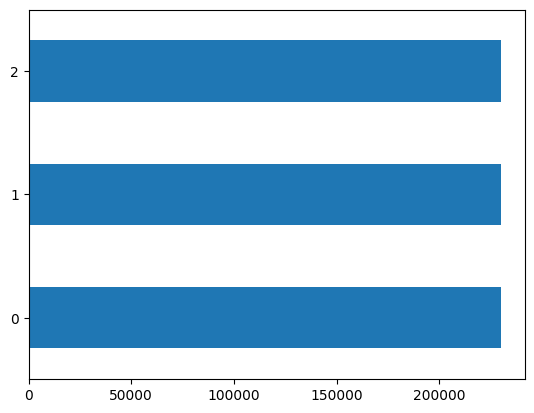

In [ ]:
ds.specimen.value_counts().plot(kind='barh')

#### Evaluation

Function: Process the evaluation dataset

In [ ]:
# @title
# # @title
# # Remove the unstable values
# na_fil = na_val[na_val['resistance_gassensor'] > 1300000]
# cf0_fil = cf0_val[cf0_val['resistance_gassensor'] < 1150000]

In [ ]:
# @title
def preprocessing_evaluation_ds(ds):
  # Calculate the number of new rows in the resulting dataframe
  num_new_rows = len(ds) // 5

  # Add the column names
  column_names = pd.Index(list(ds.columns) + ["resistance_min"] + ["resistance_max"])

  # Create a new dataframe
  new_df = pd.DataFrame(columns=column_names)

  # Iterate over the range of new rows
  for i in range(num_new_rows):
    # Get the subset of rows for averaging
    subset = ds.iloc[i * 5: (i + 1) * 5]

    # Calculate the average of each column
    averaged_row = subset.mean(axis=0)

    # Calculate the min and max resistance
    averaged_row.loc['resistance_min'] = subset['resistance_gassensor'].min()
    averaged_row.loc['resistance_max'] = subset['resistance_gassensor'].max()

    # Append the averaged row to the new dataframe
    new_df = new_df.append(averaged_row, ignore_index=True)
  # Re-order columns
  new_df = new_df[['unix_time', 'temperature', 'pressure', 'relative_humidity',
       'resistance_gassensor', 'resistance_min', 'resistance_max']]

  return new_df

In [ ]:
# @title
# # @title
# p_na_val = preprocessing_evaluation_ds(na_fil)
# p_cf0_val = preprocessing_evaluation_ds(cf0_fil)
# # p_fcf0_val = preprocessing_evaluation_ds(fcf0_val)
# # p_scl0_val = preprocessing_evaluation_ds(scl0_val)

In [ ]:
# @title
# # @title
# p_na_val = p_na_val.drop('unix_time', axis=1)
# p_cf0_val = p_cf0_val.drop('unix_time', axis=1)
# # p_fcf0_val = p_fcf0_val.drop('unix_time', axis=1)
# # p_scl0_val = p_scl0_val.drop('unix_time', axis=1)

In [ ]:
# @title
# # @title
# na_val_ds = p_na_val
# na_val_ds['specimen'] = 0
# cf0_val_ds = p_cf0_val
# cf0_val_ds['specimen'] = 1
# # fcf0_val_ds = p_fcf0_val
# # fcf0_val_ds['specimen'] = 2
# # scl0_val_ds = p_scl0_val
# # scl0_val_ds['specimen'] = 3

In [ ]:
# @title
# val_ds = pd.concat([na_val_ds, cf0_val_ds], axis=0)

### Feature scaling
Standardization

In [ ]:
features = ds.copy()
labels = features.pop('specimen')

features_val = ds_val.copy()
labels_val = features_val.pop('specimen')

The formula standardization

In [ ]:
means = features.mean()
stds = features.std()

In [ ]:
# manual standa
features_scaled = (features - means) / stds
features_val_scaled = (features_val - means) / stds

In [ ]:
# @title
# stds.values

In [ ]:
# @title
# means.values

In [ ]:
# @title
# features.describe()

In [ ]:
# @title
# features.max().values

In [ ]:
# @title
# features.min().values

[Comparision] sklearn StandardScaler

In [ ]:
# @title
# # @title
# from sklearn.preprocessing import StandardScaler
# stand = StandardScaler()
# stand_features = stand.fit_transform(features)

In [ ]:
# @title
# # @title
# sf = pd.DataFrame(stand_features)
# sf

#### PCA implementation

In [ ]:
from sklearn.decomposition import PCA

# Set the n_components=3
principal = PCA(n_components=3)
principal.fit(features_scaled)
x=principal.transform(features_scaled)

# Check the dimensions of data after PCA
print(x.shape)

(690000, 3)


In [ ]:
# Check the values of eigen vectors
# prodeced by principal components
principal.components_

array([[-1.39109844e-01,  7.87850555e-04, -1.93547721e-02,
         5.05878331e-01,  5.02569795e-01,  5.05074534e-01,
        -4.65492914e-01],
       [-3.74819064e-01,  6.23425660e-01,  6.84803936e-01,
        -2.52595597e-02, -2.33361429e-02, -2.64914513e-02,
         3.20413376e-03],
       [-8.68789943e-01, -4.74434680e-01, -5.19865442e-02,
        -7.64104103e-02, -6.79745763e-02, -8.19000861e-02,
         1.56987344e-02]])

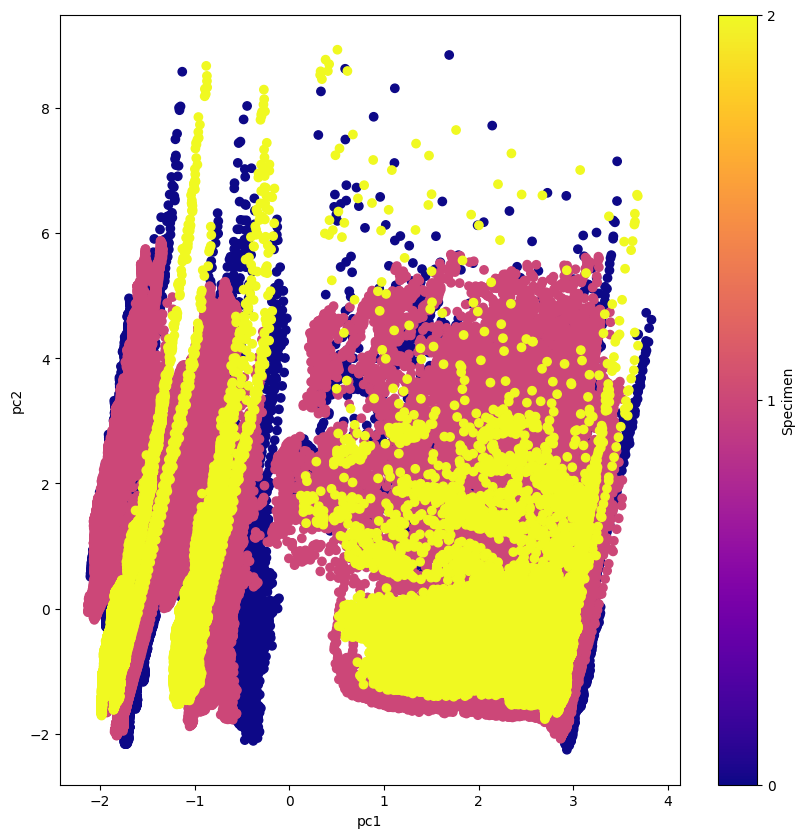

In [ ]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0],x[:,1],c=ds['specimen'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(ds['specimen']))
cbar.set_label('Specimen')

Text(0.5, 0, 'PC3')

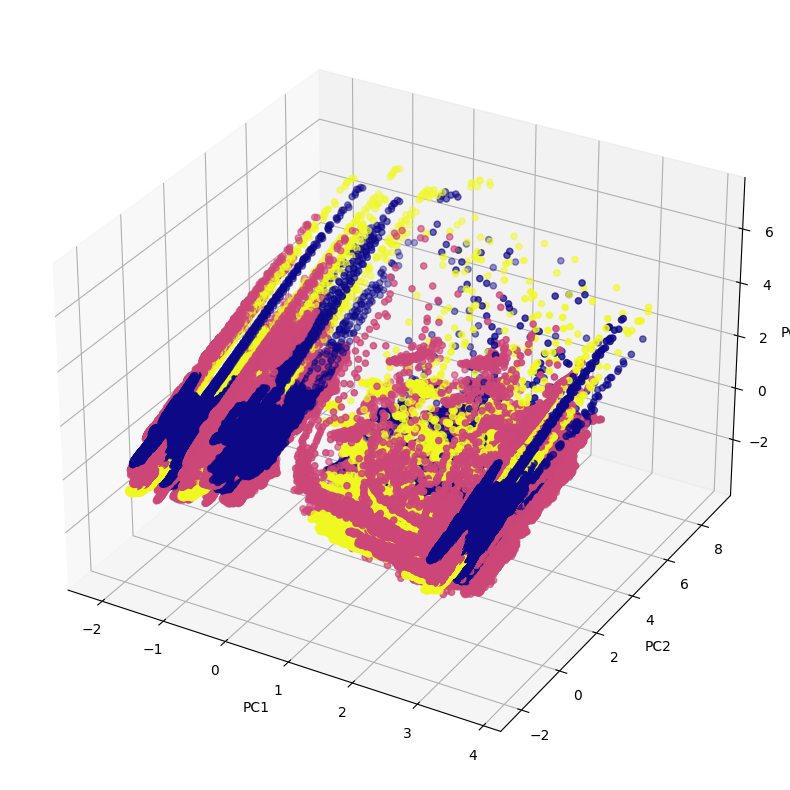

In [ ]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')

# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=ds['specimen'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)


### Split into Train and Test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42, shuffle=True)

### Convert into Tensor format

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_set = tf.data.Dataset.from_tensor_slices((features_val_scaled, labels_val))

In [ ]:
train_set = train_set.prefetch(1)
batched_train_set = train_set.batch(32)
batched_train_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# View tensors
train_input_tensor, train_output_tensor = next(iter(batched_train_set))

print(train_input_tensor)
print(train_output_tensor)

tf.Tensor(
[[ 0.24223565 -1.2662615  -0.43879829 -0.69104913 -0.67765378 -0.69404197
  -0.07923321]
 [ 0.67113557 -0.59176022 -0.52608526 -0.66526426 -0.65464861 -0.66867252
  -0.07923321]
 [-1.79721256  1.02108643  1.96968985  1.54759783  1.62331716  1.47905997
  -1.18776748]
 [ 0.77298564 -0.94725323 -0.43073116 -0.66942549 -0.65887088 -0.67604371
  -0.07923321]
 [ 0.15824592  0.8700752  -0.0207686  -0.49402102 -0.49042535 -0.48914938
  -0.07923321]
 [ 0.12880578  0.01133353 -0.64784221  1.54759783  1.62331716  1.47905997
  -1.18776748]
 [ 1.08351804 -0.09231698 -0.35589116  1.54759783  1.62331716  1.47905997
  -1.18776748]
 [-1.34645981  0.94941269 -0.0884478  -0.74649    -0.7320351  -0.75447889
   1.25100791]
 [ 0.86287799 -0.980177   -0.64962566  1.05605187  0.85769383  1.24842449
  -1.18776748]
 [-0.00659725 -0.61965629 -0.18375747 -0.67952996 -0.66695838 -0.68551782
  -0.07923321]
 [-0.93088063  1.21802686  0.82563254 -0.5170765  -0.50457744 -0.51921448
  -0.07923321]
 [ 0.11091

## 2.b Training with data from Phone

### Import dataset
Get raw data from Phone files.

#### 0507-1207

Gas 1: Normal Air

In [ ]:
na_06 = pd.read_csv('./Raw_data/phone_training/phone/0507_1207_4smells/na/NormalAir_0607_0900_1600_phone.csv') # Normal Air 9h [6/7] - 16h [6/7]
na_07 = pd.read_csv('./Raw_data/phone_training/phone/0507_1207_4smells/na/NormalAir_0707_0900_1600_phone.csv') # Normal Air 9h [7/7] - 16h [7/7]

Gas 2: Caffee

In [ ]:
cf_05 = pd.read_csv('./Raw_data/phone_training/phone/0507_1207_4smells/cf/Caffee_0507_1600_0900_phone.csv')

Gas 3: Food Caffee

In [ ]:
fcf_06 = pd.read_csv('./Raw_data/phone_training/phone/0507_1207_4smells/fcf/FoodCaffee_0707_1600_0900_phone.csv') # FoodCaffee 16h [6/7] - 9h [7/7]

Gas 4: Food Socola

In [ ]:
# scl_0707 = pd.read_csv('./Raw_data/phone_training/phone/0507_1207_4smells/scl/Socola_0707_1600_1600_phone.csv')

#### 1207 - now

Gas 1: Normal Air

In [ ]:
na_13 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/na/NormalAir_1307_0810_0910_removed_phone.csv')
na_14_07 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/na/NormalAir_1407_0740_0840_removed_phone.csv')
na_14_08 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/na/NormalAir_1407_0850_0950_removed_phone.csv')

In [ ]:
na_val = pd.read_csv('./Raw_data/phone_eval/NormalAir_1407_1015_1115_phone.csv')
na_val.shape

(3365, 5)

Gas 2: Caffee

In [ ]:
cf_12 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/cf/Caffee_1207_1720_1307_0800_removed_phone.csv') # Caffee 16h [5/7] - 9h [6/7]

In [ ]:
cf_val = pd.read_csv('./Raw_data/phone_eval/Caffee_1407_1115_1220_phone.csv')
cf_val.shape

(3489, 5)

Gas 3: Food Caffee

In [ ]:
fcf_13_09 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/fcf/FoodCaffee_1307_0915_1345_removed_phone.csv')
fcf_13_17 = pd.read_csv('./Raw_data/phone_training/phone/1207_10s_sampling/fcf/FoodCaffee_1307_1720_1407_0730_removed_phone.csv')

In [ ]:
fcf_val = pd.read_csv('./Raw_data/phone_eval/FoodCaffee_1407_1220_1340_phone.csv')
fcf_val.shape

(4482, 5)

### Functions

In [ ]:
_list = [na_val,cf_val,fcf_val, na_06,na_07,cf_05,fcf_06, na_13,na_14_07,na_14_08,cf_12,fcf_13_09,fcf_13_17]

Visualize missing values.

In [ ]:
def check_missing_values(ds):
  sns.heatmap(ds.isnull(), cbar=False)

Fast check: Missing values

In [ ]:
for i in _list:
  print(i.isnull().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0


Fix humidity

In [ ]:
#@title
# def fix_humidity(list_):
#   for ds in list_:
#     if ds.loc[0,'relative_humidity'] > 100.0:
#       ds['relative_humidity'] = ds['relative_humidity'] / 1000.0

In [ ]:
#@title
# list_ = [na1,na2,na3,na4,na5,cf1,cf2,scl1]
# fix_humidity(list_)

Check duplicate:

In [ ]:
def check_duplicate(df):
  duplicate_rows = df.duplicated(subset=['temperature','pressure','relative_humidity','resistance_gassensor'],keep='first')
  print(duplicate_rows.sum())

In [ ]:
for i in _list:
  check_duplicate(i)

0
0
0
0
0
0
0
0
0
0
0
0
0


**Functions**

Eliminate duplicate data points in the raw data set. This removal is not necessary because the data can be processed for averaging later.

In [ ]:
# Pre-process: Remove the duplicated data
def remove_duplicated_datas(df):

  # Check for duplicate rows
  duplicate_rows = df.duplicated(subset=['temperature','pressure','relative_humidity','resistance_gassensor'],keep='first')

  # Select rows that are not duplicates
  df = df[~duplicate_rows]

  return df

### Data overview
Datasets over time.

Function

In [ ]:
# Function: Visualize the gas resistance over time in a dataset from phone with options:
# Args:
# 1. RAW dataset
# 2. short: full or partial?
def visualize_raw_dataset_from_phone(dataset, name, short=True, fig=None, ax=None):
  if fig is None or ax is None:
    # Create a figure
    fig, ax = plt.subplots(figsize=(12,6))

  # Short dataset
  if short:
    dataset = dataset.iloc[:200]

  ax.plot(dataset["unix_time"], dataset["resistance_gassensor"], label='{}'.format(name), marker='o', markersize=5)
  # Set the labels and title
  ax.set_xlabel("Unix_time [s]")
  ax.set_ylabel("Resistance_gassensor [Ohm]")
  ax.set_title("Unix_time vs. Resistance_gassensor")
  ax.legend()

Visualize: All specimens over time

In [ ]:
# na
na_dict = {
    'na_06':na_06,
    'na_07':na_07,
    'na_13':na_13,
    'na_14_07':na_14_07,
    'na_14_08':na_14_08,

    'na_val':na_val
}
# cf
cf_dict = {
    'cf_05':cf_05,
    'cf_12':cf_12,

    'cf_val':cf_val,
}
# fcf
fcf_dict = {
    'fcf_06':fcf_06,
    'fcf_13_09':fcf_13_09,
    'fcf_13_17':fcf_13_17,

    'fcf_val':fcf_val
}
# scl
# scl_dict = {
#     'scl_0707':scl_0707
# }

List of raw datasets of each specimen:

In [ ]:
dict_list = [na_dict, cf_dict, fcf_dict]

One picture for each specimen

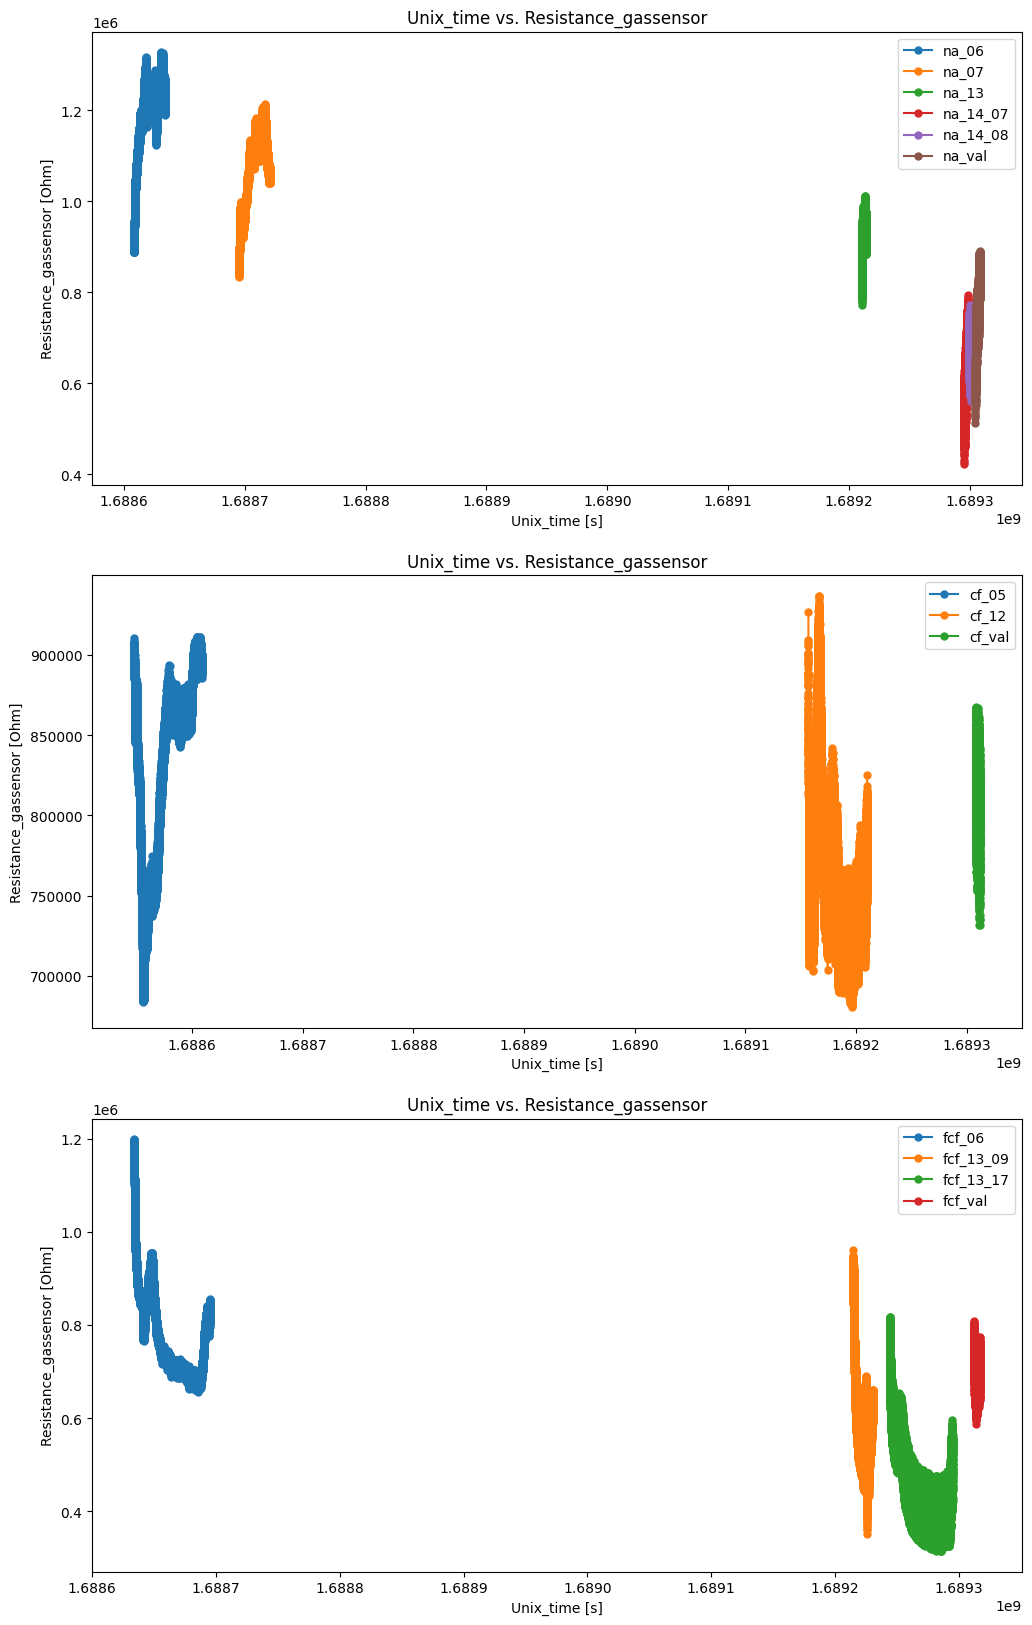

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(12,20))

for i in range(len(dict_list)):
  for name, ds in dict_list[i].items():
    visualize_raw_dataset_from_phone(ds, name, short=False, fig=fig, ax=ax[i])

All in one picture

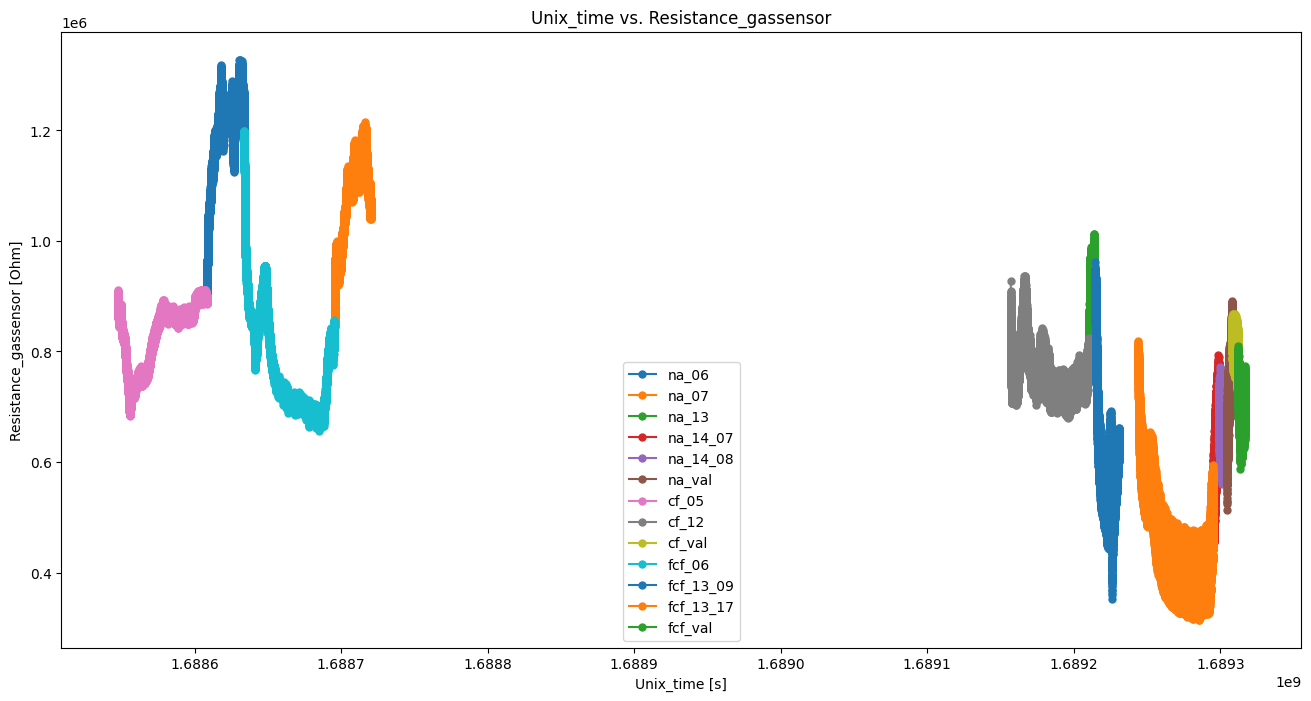

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for i in range(len(dict_list)):
  for name, ds in dict_list[i].items():
    visualize_raw_dataset_from_phone(ds, name, short=False, fig=fig, ax=ax)

### Specimen overview & data preprocessing
Please choose a specimen data:

In [ ]:
_list = [na_val,cf_val,fcf_val, na_06,na_07,cf_05,fcf_06, na_13,na_14_07,na_14_08,cf_12,fcf_13_09,fcf_13_17]

In [ ]:
ds = fcf_val.copy()

Visualize: Original raw data.

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

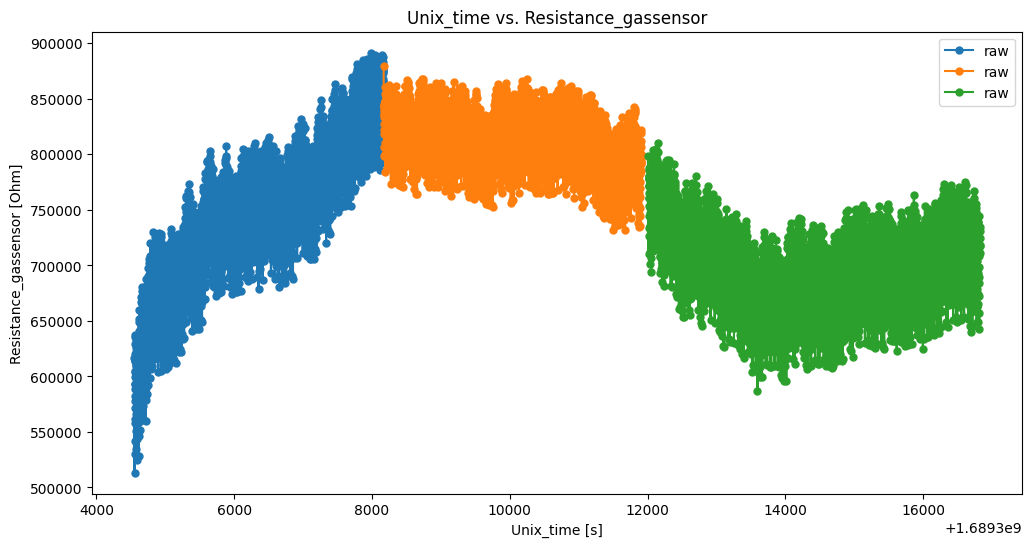

In [ ]:
visualize_raw_dataset_from_phone(ds, "raw", short=False, fig=fig, ax=ax)
fig

#### Remove: Outliers

**Input dataset description**

One dataset from one session measurement.

Please choose a dataset:

In [ ]:
ds = cf_1207.copy()

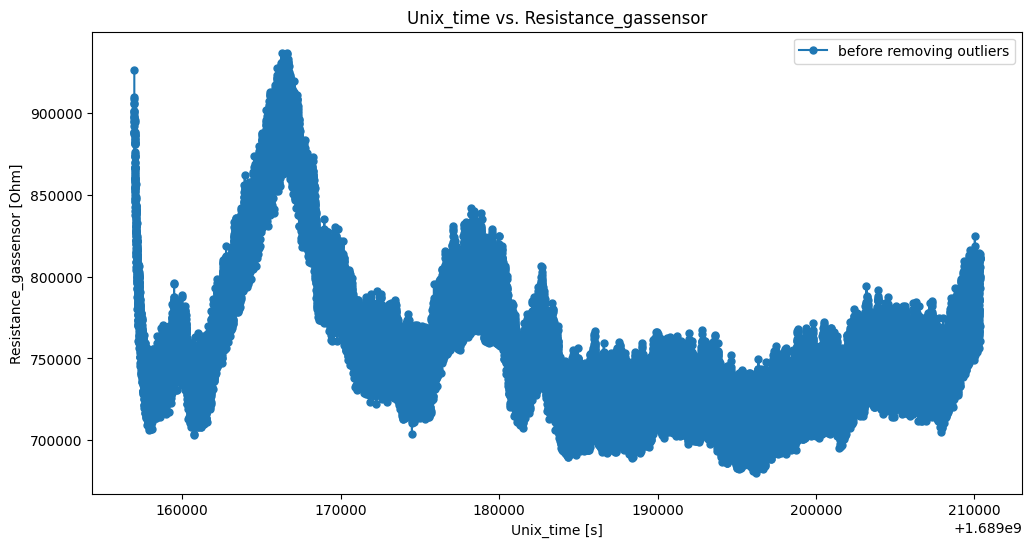

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
visualize_raw_dataset_from_phone(ds, "before removing outliers", short=False, fig=fig, ax=ax)

Remove

In [ ]:
from scipy import stats

def remove_outliers(df, column_name, threshold=3):
    """
    Remove outliers from a dataframe column using Z-score.

    Args:
        df (pandas.DataFrame): Input dataframe.
        column (str): Name of the column to remove outliers from.
        threshold (float): Z-score threshold for considering a data point as an outlier. Default is 3.

    Returns:
        pandas.DataFrame: Dataframe with outliers removed.
    """
    z_scores = stats.zscore(df[column_name])
    df_no_outliers = df.loc[abs(z_scores) <= threshold].copy()
    return df_no_outliers

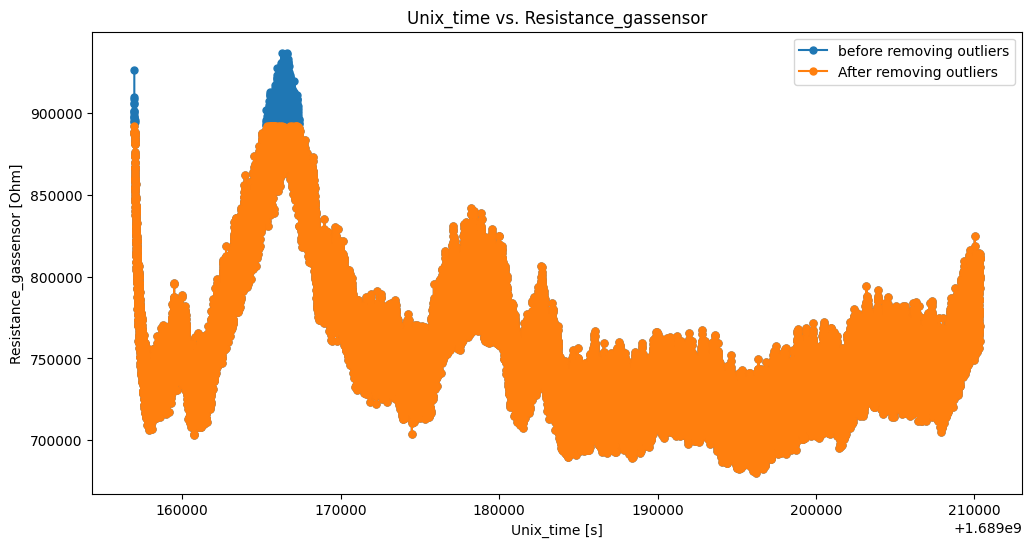

In [ ]:
ds_no_outliers = remove_outliers(ds, "resistance_gassensor", 3)
visualize_raw_dataset_from_phone(ds_no_outliers, "After removing outliers", short=False, fig=fig, ax=ax)
fig

Function calling: Remove outliers

In [ ]:
# na_0607_no_outliers = remove_outliers(na_0607, "resistance_gassensor")
# na_0707_no_outliers = remove_outliers(na_0707, "resistance_gassensor")
# cf_0507_no_outliers = remove_outliers(cf_0507, "resistance_gassensor")
# fcf_0707_no_outliers = remove_outliers(fcf_0707, "resistance_gassensor")
# scl_0707_no_outliers = remove_outliers(scl_0707, "resistance_gassensor")

In [ ]:
# na_val = remove_outliers(na_val, "resistance_gassensor")

Visualize: All specimens over time. After removing outliers

In [ ]:
# na
na_dict = {
    'na_0607_no_outliers':na_0607_no_outliers,
    'na_0707_no_outliers':na_0707_no_outliers
}
# cf
cf_dict = {
    'cf_0507_no_outliers':cf_0507_no_outliers
}
# fcf
fcf_dict = {
    'fcf_0707_no_outliers':fcf_0707_no_outliers
}
# scl
scl_dict = {
    'scl_0707_no_outliers':scl_0707_no_outliers
}

no_outliers_list = [na_dict, cf_dict, fcf_dict, scl_dict]

All in one picture: After removing outliers

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

for i in range(len(no_outliers_list)):
  for name, ds in no_outliers_list[i].items():
    visualize_raw_dataset_from_phone(ds, name, short=False, fig=fig, ax=ax)

#### Concat
Concat into one specimen and sort by time

In [ ]:
_list = [na_val,cf_val,fcf_val, na_06,na_07,cf_05,fcf_06, na_13,na_14_07,na_14_08,cf_12,fcf_13_09,fcf_13_17]

In [ ]:
# na1 from 0507
na1 = pd.concat([na_06, na_07], axis=0, ignore_index=True)
na1 = na1.sort_values(by=["unix_time"])

In [ ]:
# na2 from 1207
na2 = pd.concat([na_13, na_14_07, na_14_08], axis=0, ignore_index=True)
na2 = na2.sort_values(by=["unix_time"])

In [ ]:
# cf1 from 0507
cf1 = cf_05

# cf2 from 1207
cf2 = cf_12

In [ ]:
# fcf1 from 0507
fcf1 = fcf_06

# fcf2 from 1207
fcf2 = pd.concat([fcf_13_09, fcf_13_17], axis=0, ignore_index=True)
fcf2 = fcf2.sort_values(by=["unix_time"])

In [ ]:
print(f"Shape of na1 : {na1.shape}")
print(f"Shape of na2 : {na2.shape}")
print(f"Shape of cf1 : {cf1.shape}")
print(f"Shape of cf2 : {cf2.shape}")
print(f"Shape of fcf1 : {fcf1.shape}")
print(f"Shape of fcf2 : {fcf2.shape}")

Shape of na1 : (84938, 5)
Shape of na2 : (10225, 5)
Shape of cf1 : (99624, 5)
Shape of cf2 : (47586, 5)
Shape of fcf1 : (101771, 5)
Shape of fcf2 : (60847, 5)


#### Visualize: All specimens - The distribution

Text(0, 0.5, 'Frequency')

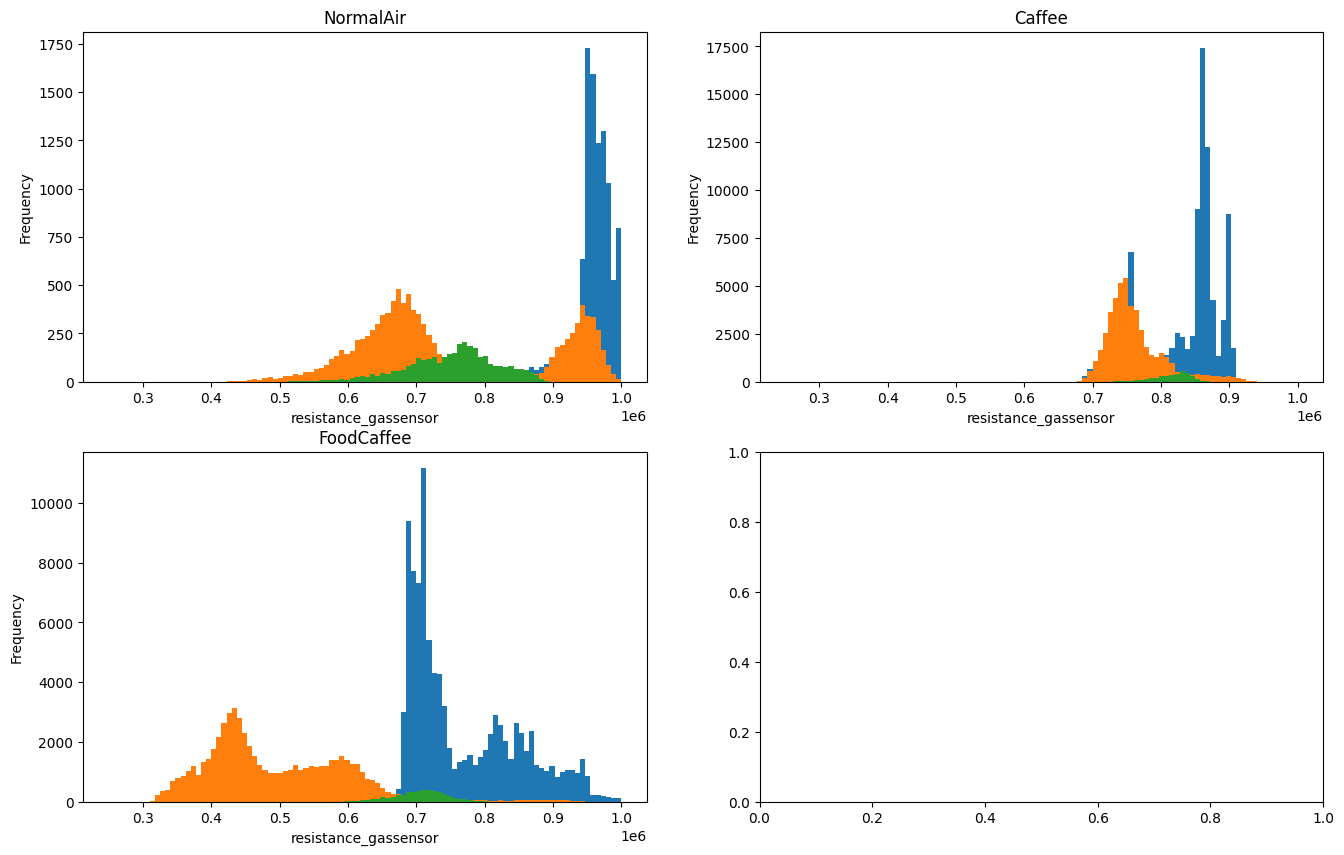

In [ ]:
fig_dis, ax_dis = plt.subplots(2,2, figsize=(16,10))

x_min = 0.25e6
x_max = 1e6
# y_max = 5600

ax_dis[0,0].hist(na1['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Normal Air
ax_dis[0,0].hist(na2['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Normal Air
ax_dis[0,0].hist(na_val['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Normal Air
ax_dis[0,0].set_title('NormalAir')
# ax_dis[0,0].set_ylim(0,y_max)
ax_dis[0,0].set_xlabel('resistance_gassensor')
ax_dis[0,0].set_ylabel('Frequency')

ax_dis[0,1].hist(cf1['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Caffee
ax_dis[0,1].hist(cf2['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Caffee
ax_dis[0,1].hist(cf_val['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Caffee
ax_dis[0,1].set_title('Caffee')
# ax_dis[0,1].set_ylim(0,y_max)
ax_dis[0,1].set_xlabel('resistance_gassensor')
ax_dis[0,1].set_ylabel('Frequency')

ax_dis[1,0].hist(fcf1['resistance_gassensor'], bins=100, range=(x_min, x_max)) # FoodCaffee
ax_dis[1,0].hist(fcf2['resistance_gassensor'], bins=100, range=(x_min, x_max)) # FoodCaffee
ax_dis[1,0].hist(fcf_val['resistance_gassensor'], bins=100, range=(x_min, x_max)) # FoodCaffee
ax_dis[1,0].set_title('FoodCaffee')
# ax_dis[1,0].set_ylim(0,y_max)
ax_dis[1,0].set_xlabel('resistance_gassensor')
ax_dis[1,0].set_ylabel('Frequency')

# ax_dis[1,1].hist(scl['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Socola
# ax_dis[1,1].set_title('Socola')
# ax_dis[1,1].set_xlabel('resistance_gassensor')
# ax_dis[1,1].set_ylabel('Frequency')

In [ ]:
# ax_dis[0,0].hist(na_val['resistance_gassensor'], bins=100, range=(x_min, x_max)) # Normal Air validation
# fig_dis

#### Visualize: One specimen - RAW features over time
Please choose a dataset

In [ ]:
ds = na.copy()

Text(0, 0.5, 'Value')

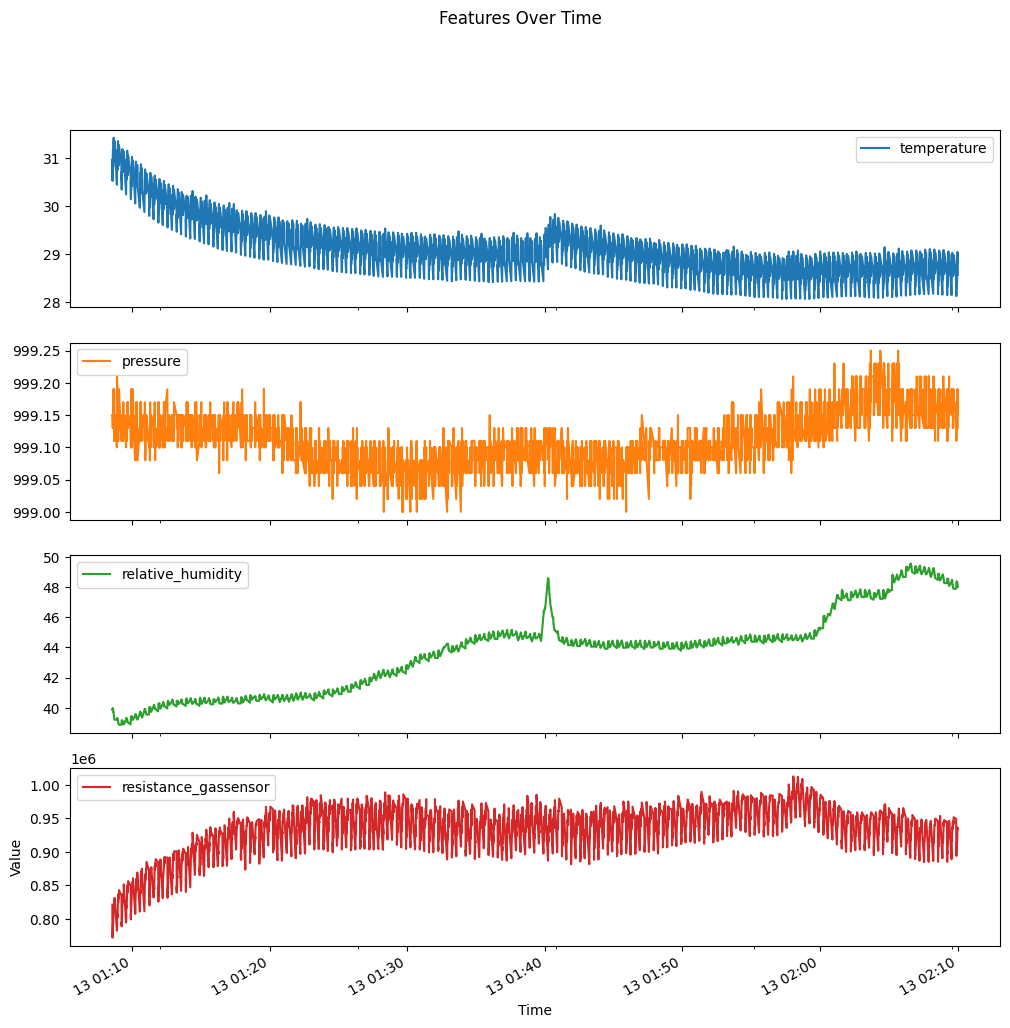

In [ ]:
# Convert "unix_time" column to datetime format
ds['unix_time'] = pd.to_datetime(ds['unix_time'], unit='s')

# Set "unix_time" as the index
ds.set_index('unix_time', inplace=True)

ds.plot(y=["temperature",	"pressure",	"relative_humidity",	"resistance_gassensor"], subplots=True, layout=(4,1), figsize=(12,12))

# Add titles and labels
plt.suptitle('Features Over Time')
plt.xlabel('Time')
plt.ylabel('Value')

#### Feature extraction
From raw features, calculate the minimum, maximum, mean and standard deviation values of  gas resistance and the mean value of other features of each gas specimens in short time windows (1.5s).

Please choose a input raw dataset

In [ ]:
_list = [na_val,cf_val,fcf_val, na_06,na_07,cf_05,fcf_06, na_13,na_14_07,na_14_08,cf_12,fcf_13_09,fcf_13_17]

DWT

In [ ]:
na_13.columns

Index(['unix_time', 'temperature', 'pressure', 'relative_humidity',
       'resistance_gassensor'],
      dtype='object')

In [ ]:
# Extract the "resistance" column as a numpy array
na_res = na_13['resistance_gassensor'].values
na_res

array([821078., 771889., 779070., ..., 944993., 945660., 948337.])

In [ ]:
import pywt

# Apply DWT to the resistance data
wavelet = 'db4'  # Choose a wavelet function, such as 'db4'
coeffs = pywt.wavedec(na_res, wavelet)

In [ ]:
import pywt

In [ ]:
ds = na_14_07.copy()
ds[:30]

unix_time  temperature  pressure  relative_humidity  resistance_gassensor
0   1689295154        30.49    999.08             48.706              423091.0
1   1689295155        30.86    999.11             48.706              446518.0
2   1689295155        31.03    999.11             48.706              461289.0
3   1689295155        31.14    999.10             48.706              477071.0
4   1689295156        31.21    999.10             48.706              488919.0
5   1689295156        31.25    999.11             48.706              500996.0
6   1689295157        31.31    999.11             48.706              509384.0
7   1689295157        31.37    999.13             48.706              520880.0
8   1689295158        30.88    999.08             48.396              517257.0
9   1689295159        31.16    999.11             48.396              531637.0
10  1689295159        31.29    999.10             48.396              539348.0
11  1689295160        30.87    999.10             48.203              530794.0
12  1689295161        31.16    999.10             48.203              543288.0
13  1689295161        31.28    999.13             48.203              550889.0
14  1689295162        30.87    999.10             48.066              544614.0
15  1689295163        31.16    999.11             48.066              552709.0
16  1689295163        31.30    999.11             48.066              561990.0
17  1689295174        30.88    999.08             47.953              556385.0
18  1689295175        30.40    999.04             48.393              427141.0
19  1689295175        30.77    999.11             48.393              444148.0
20  1689295176        30.57    999.10             48.393              456569.0
21  1689295176        30.89    999.11             48.393              469376.0
22  1689295177        31.04    999.10             48.393              481880.0
23  1689295178        30.67    999.08             48.393              483271.0
24  1689295178        30.98    999.08             48.393              494336.0
25  1689295179        31.11    999.10             48.393              508997.0
26  1689295179        31.19    999.11             48.393              519667.0
27  1689295180        31.25    999.11             48.393              527447.0
28  1689295180        31.30    999.10             48.393              535037.0
29  1689295181        30.81    999.10             48.134              532907.0

**Input dataset description**
*   Format: Dataframe
*   Rows: Raw data samples
*   Columns: Gas features include: '*unix_time*', '*temperature*', '*pressure*', '*relative_humidity*', '*resistance_gassensor*'.







Function

In [ ]:
def preprocess_features(ds):

  # Convert "unix_time" column to datetime format
  ds['unix_time'] = pd.to_datetime(ds['unix_time'], unit='s')

  # Set "unix_time" as the index
  ds.set_index('unix_time', inplace=True)

  # Resample the data every 10 seconds and aggregate the values ==================>>>>>>>>>>>> Fix here to change group time
  resampled_ds = ds.resample('10S', origin='start').agg({
      'temperature': 'mean',
      'pressure': 'mean',
      'relative_humidity': 'mean',
      'resistance_gassensor': ['mean', 'min', 'max']
  })

  # Flatten the multi-level column names
  resampled_ds.columns = [f'{agg}_{col}' for col, agg in resampled_ds.columns]

  # Reset the index
  resampled_ds.reset_index(inplace=True)

  # Convert "unix_time" column back to Unix time format
  resampled_ds['unix_time'] = resampled_ds['unix_time'].astype(int) // 10**9

  return resampled_ds

In [ ]:
preprocessed_ds = preprocess_features(ds)

Check missing values

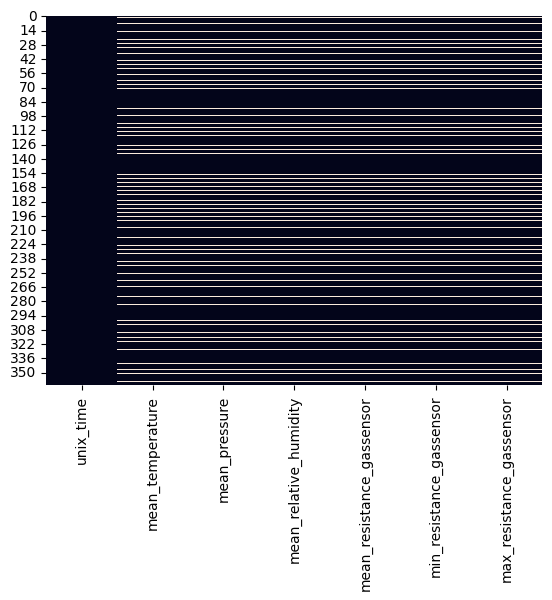

In [ ]:
check_missing_values(preprocessed_ds)

**Why treat like this?**

Because: considering the data sampling from the sensor to the app, the data being pushed up is similar to the data collected for training

**Function calling to perform feature extraction**

In [ ]:
# visualize_raw_dataset_from_phone(scl_0707_no_outliers, "Remove outlier values", short=False)

Function calling: **From the data are removed outliers, extract features in short time windows (1.5s).**

In [ ]:
_list = [na_val,cf_val,fcf_val, na_06,na_07,cf_05,fcf_06, na_13,na_14_07,na_14_08,cf_12,fcf_13_09,fcf_13_17]

In [ ]:
# p: preprocessed
# from 0507
p_na_06 = preprocess_features(na_06)
p_na_07 = preprocess_features(na_07)
p_cf_05 = preprocess_features(cf_05)
p_fcf_06 = preprocess_features(fcf_06)

# from 1207
p_na_13 = preprocess_features(na_13)
p_na_14_07 = preprocess_features(na_14_07)
p_na_14_08 = preprocess_features(na_14_08)
p_cf_12 = preprocess_features(cf_12)
p_fcf_13_09 = preprocess_features(fcf_13_09)
p_fcf_13_17 = preprocess_features(fcf_13_17)

# validation
p_na_val = preprocess_features(na_val)
p_cf_val = preprocess_features(cf_val)
p_fcf_val = preprocess_features(fcf_val)

In [ ]:
_list = [p_na_06,p_na_07,p_cf_05,p_fcf_06, p_na_13,p_na_14_07,p_na_14_08,p_cf_12,p_fcf_13_09,p_fcf_13_17, p_na_val, p_cf_val, p_fcf_val]

### Data cleaning

#### Missing values

In [ ]:
for i in _list:
  print(i.isnull().sum().sum())

0
0
0
0
402
342
246
5862
1548
4716
174
198
282


Function

In [ ]:
def replace_and_remove_null(ds):
  result_ds = ds
  # Remove NaN rows
  result_ds = result_ds.dropna()
  result_ds = result_ds.reset_index(drop=True)

  return result_ds

Visualize a dataset that removed missing values and preprocessed.

In [ ]:
# Function: Visualize the gas resistance over time in a dataset from phone with options:
# Args:
# 1. A Preprocessed dataset
# 2. short: full or partial?
# 3. fig: figure
# 4. ax: axis

def visualize_a_preprocessed_dataset_from_phone(dataset, name, short=True, fig=None, ax=None):
  if fig is None or ax is None:
    # Create a figure
    fig, ax = plt.subplots(figsize=(12,6))

  # Short dataset
  if short:
    dataset = dataset.iloc[:20]

  ax.plot(dataset["unix_time"], dataset["mean_resistance_gassensor"], label='mean', marker='v', markersize=5)
  ax.plot(dataset["unix_time"], dataset["min_resistance_gassensor"], label='min', marker='s', markersize=3)
  ax.plot(dataset["unix_time"], dataset["max_resistance_gassensor"], label='max', marker='o', markersize=3)
  # Set the labels and title
  ax.set_xlabel("Unix_time [s]")
  ax.set_ylabel("Resistance_gassensor [Ohm]")
  ax.set_title("Unix_time vs. Resistance_gassensor")
  ax.legend()

In [ ]:
non_null_ds = replace_and_remove_null(preprocessed_ds)

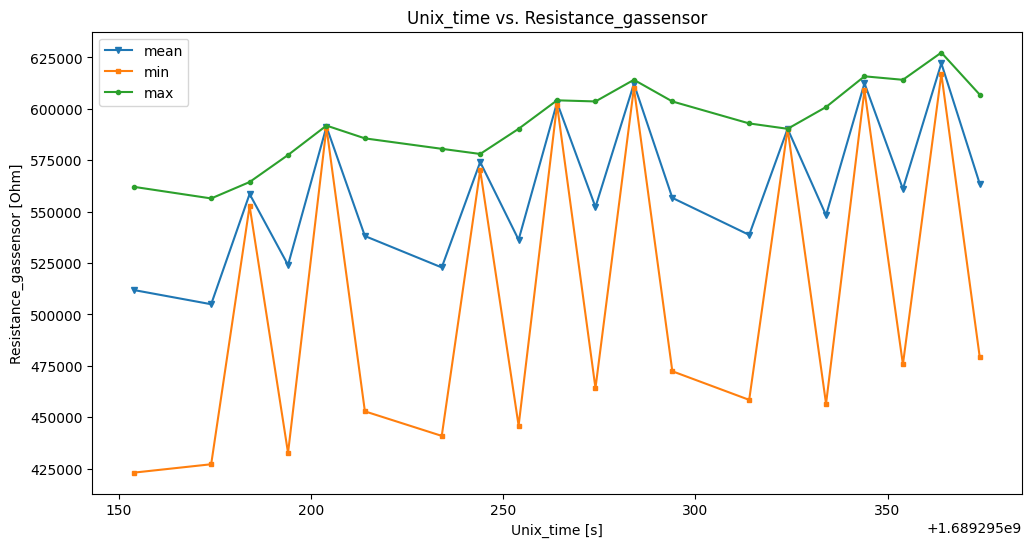

In [ ]:
visualize_a_preprocessed_dataset_from_phone(non_null_ds, "preprocessed", short=True)

Function calling

In [ ]:
_list = [p_na_06,p_na_07,p_cf_05,p_fcf_06, p_na_13,p_na_14_07,p_na_14_08,p_cf_12,p_fcf_13_09,p_fcf_13_17, p_na_val, p_cf_val, p_fcf_val]

In [ ]:
# nn: non null
# from 0507
nn_na_06 = replace_and_remove_null(p_na_06)
nn_na_07 = replace_and_remove_null(p_na_07)
nn_cf_05 = replace_and_remove_null(p_cf_05)
nn_fcf_06 = replace_and_remove_null(p_fcf_06)

# from 1207
nn_na_13 = replace_and_remove_null(p_na_13)
nn_na_14_07 = replace_and_remove_null(p_na_14_07)
nn_na_14_08 = replace_and_remove_null(p_na_14_08)
nn_cf_12 = replace_and_remove_null(p_cf_12)
nn_fcf_13_09 = replace_and_remove_null(p_fcf_13_09)
nn_fcf_13_17 = replace_and_remove_null(p_fcf_13_17)

# validation
nn_na_val = replace_and_remove_null(p_na_val)
nn_cf_val = replace_and_remove_null(p_cf_val)
nn_fcf_val = replace_and_remove_null(p_fcf_val)

In [ ]:
_list = [nn_na_06,nn_na_07,nn_cf_05,nn_fcf_06,nn_na_13,nn_na_14_07,nn_na_14_08,nn_cf_12,nn_fcf_13_09,nn_fcf_13_17,nn_na_val,nn_cf_val,nn_fcf_val]

In [ ]:
for i in _list:
  print(i.isnull().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0


### Concat into specimens

In [ ]:
_list = [nn_na_06,nn_na_07,nn_cf_05,nn_fcf_06, nn_na_13,nn_na_14_07,nn_na_14_08,nn_cf_12,nn_fcf_13_09,nn_fcf_13_17, nn_na_val,nn_cf_val,nn_fcf_val ]

In [ ]:
na = pd.concat([nn_na_06, nn_na_07,nn_na_13,nn_na_14_07,nn_na_14_08], axis=0)
na = na.sort_values(by=["unix_time"])


cf = pd.concat([nn_cf_05,nn_cf_12], axis=0)
cf = cf.sort_values(by=["unix_time"])

fcf = pd.concat([nn_fcf_06,nn_fcf_13_09,nn_fcf_13_17], axis=0)
fcf = fcf.sort_values(by=["unix_time"])

# scl = non_null_scl_0707
# scl = scl.sort_values(by=["unix_time"])

In [ ]:
na_val = nn_na_val
cf_val = nn_cf_val
fcf_val = nn_fcf_val

### Get feature columns

In [ ]:
na.pop('unix_time')
cf.pop('unix_time')
fcf.pop('unix_time')
# scl.pop('unix_time')

0       1688633994
1       1688634004
2       1688634014
3       1688634024
4       1688634034
           ...    
4294    1689294774
4295    1689294794
4296    1689294804
4297    1689294814
4298    1689294834
Name: unix_time, Length: 11813, dtype: int64

In [ ]:
na_val.pop('unix_time')
cf_val.pop('unix_time')
fcf_val.pop('unix_time')

0      1689312014
1      1689312024
2      1689312034
3      1689312044
4      1689312054
          ...    
429    1689316774
430    1689316784
431    1689316794
432    1689316804
433    1689316814
Name: unix_time, Length: 434, dtype: int64

### Labeling
The number of smells is equivalent to the number of specimens. The need to fill in the full label name in the [labels.txt](https://drive.google.com/file/d/1Z8j4NWCd5tY8MuADV3mOeTmxs0Ws1Ntb/view?usp=drive_link) file and in the correct order.

In [ ]:
na['specimen'] = 0
na_val['specimen'] = 0


cf['specimen'] = 1
cf_val['specimen'] = 1

fcf['specimen'] = 2
fcf_val['specimen'] = 2


# scl['specimen'] = 3

In [ ]:
print(f"Shape of DataFrame na: {na.shape}")
print(f"Shape of DataFrame cf: {cf.shape}")
print(f"Shape of DataFrame fcf: {fcf.shape}")

Shape of DataFrame na: (6011, 7)
Shape of DataFrame cf: (10465, 7)
Shape of DataFrame fcf: (11813, 7)


In [ ]:
# scl.shape

### Slicing

In [ ]:
na_specimen = na[:6000]

cf_specimen = cf[:6000]

fcf_specimen = fcf[:6000]

# scl_specimen = scl[:10000]

### Concat specimens into a dataset

In [ ]:
ds = pd.concat([na_specimen,cf_specimen,fcf_specimen], axis=0)
# ds = pd.concat([na,cf,fcf], axis=0)

In [ ]:
ds_val = pd.concat([na_val,cf_val,fcf_val])

<Axes: >

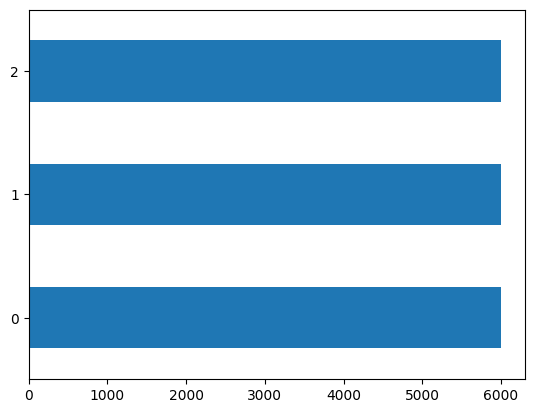

In [ ]:
ds.specimen.value_counts().plot(kind='barh')

<Axes: >

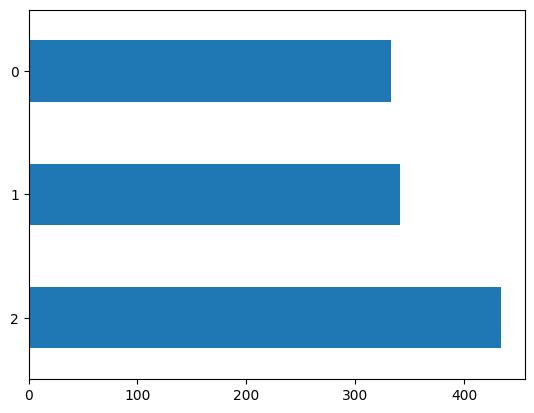

In [ ]:
ds_val.specimen.value_counts().plot(kind='barh')

### Feature scaling
Standardization

In [ ]:
features = ds.iloc[:,:-1]
labels = ds['specimen']

In [ ]:
x_val = ds_val.copy()
y_val = x_val.pop('specimen')

In [ ]:
means = features.mean()
stds = features.std()

The formula:

In [ ]:
features_scaled = (features - means) / stds

In [ ]:
x_val_scaled = (x_val - means) / stds

Save **mean**, **standard deviation**, **min** and **max** values to [metadata_writer.py](https://drive.google.com/file/d/1_xjQKQ6K08Xw6COO3cLBbaAm1BH3YFSx/view?usp=drive_link) file to use for **Code generator**. Min and max values are optional.

In [ ]:
stds.values

array([2.17498561e+00, 1.09613737e+00, 3.69354419e+00, 1.78652715e+05,
       1.79626552e+05, 1.78825216e+05])

In [ ]:
means.values

array([3.37255957e+01, 9.99335335e+02, 4.34185907e+01, 8.93966346e+05,
       8.85108428e+05, 9.02426022e+05])

In [ ]:
# features.max().values

In [ ]:
# features.min().values

[Comparision] sklearn StandardScaler

In [ ]:
#@title
# #@title
# from sklearn.preprocessing import StandardScaler
# stand = StandardScaler()
# stand_features = stand.fit_transform(features)

In [ ]:
#@title
# features_scaled.columns

In [ ]:
#@title
# sf = pd.DataFrame(stand_features)
# sf

#### PCA implementation

In [ ]:
from sklearn.decomposition import PCA

# Set the n_components=3
principal = PCA(n_components=3)
principal.fit(features_scaled)
x=principal.transform(features_scaled)

# Check the dimensions of data after PCA
print(x.shape)

(18000, 3)


In [ ]:
# Check the values of eigen vectors
# prodeced by principal components
principal.components_

array([[-0.38670519, -0.19037172, -0.32721337,  0.48601916, -0.00574693,
         0.48418568,  0.48627738],
       [-0.43798718, -0.02184149,  0.38725832, -0.0228993 ,  0.80783919,
        -0.067676  ,  0.00354947],
       [ 0.04840724, -0.93153224, -0.21814865, -0.15703049,  0.08833825,
        -0.16141831, -0.15426439]])

2D

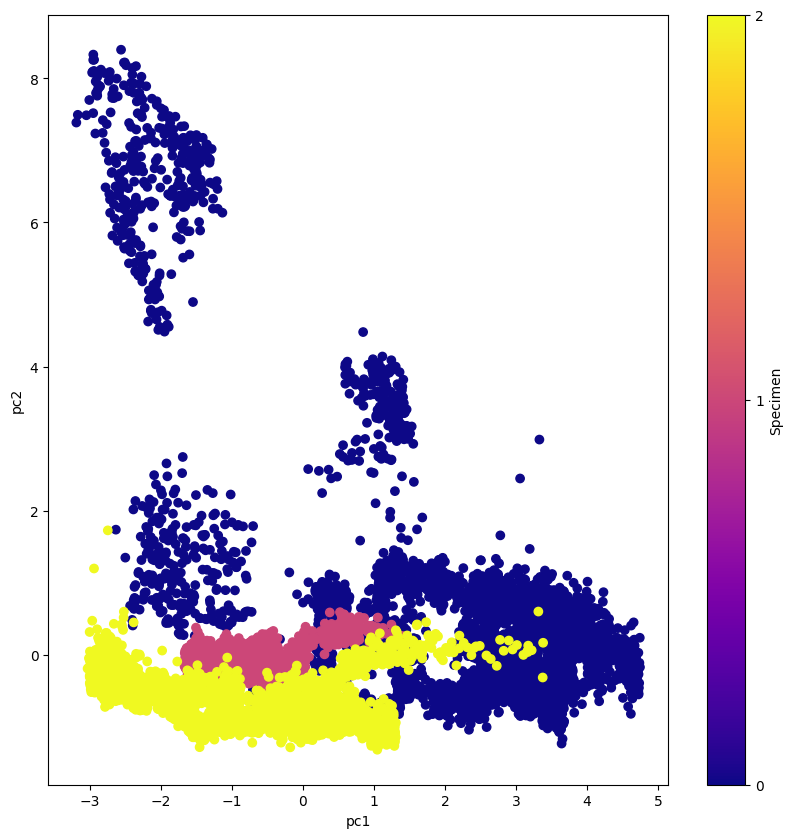

In [ ]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(x[:,0],x[:,1],c=ds['specimen'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(ds['specimen']))
cbar.set_label('Specimen')

3D

Text(0.5, 0, 'PC3')

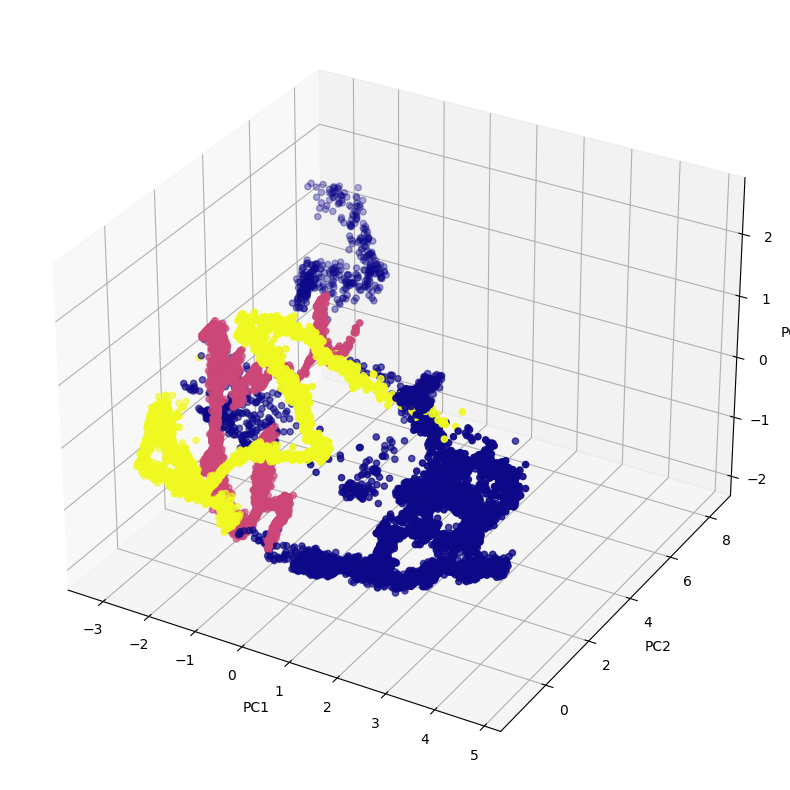

In [ ]:
# import relevant libraries for 3d graph
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))

# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')

# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=ds['specimen'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)


#### LDA implementation

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# initializing the model with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
# fitting the dataset
X_r2 = lda.fit(features, labels).transform(features)

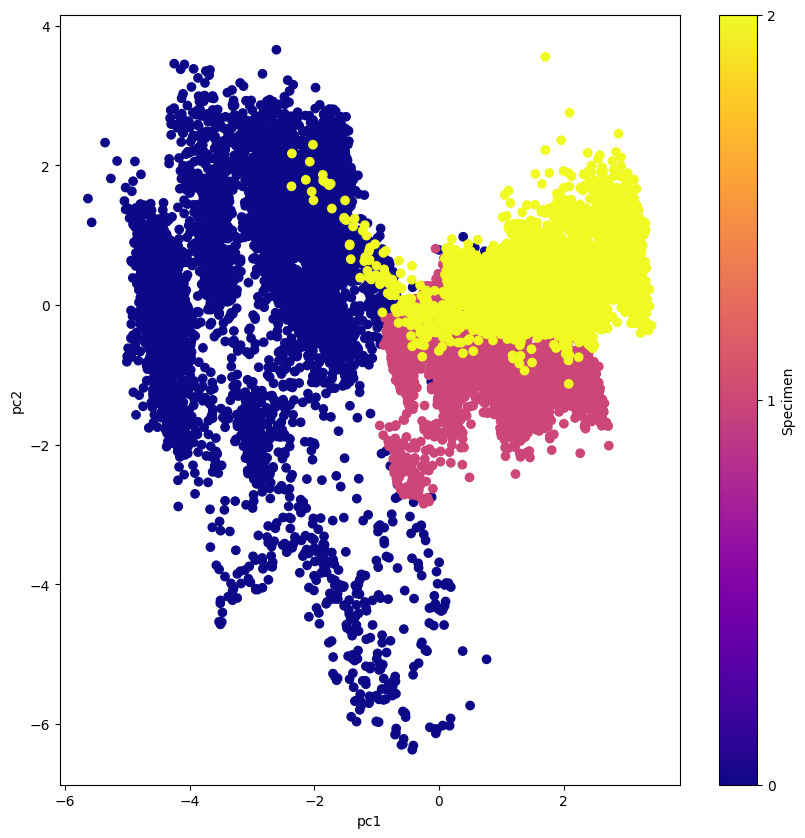

In [ ]:
# plot size
plt.figure(figsize=(10,10))
scatter = plt.scatter(X_r2[:,0],X_r2[:,1],c=ds['specimen'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

# Add a colorbar for the 'specimen' labels
cbar = plt.colorbar(scatter, ticks=np.unique(ds['specimen']))
cbar.set_label('Specimen')

In [ ]:
feat_lda = pd.DataFrame(X_r2, columns=['feature1','feature2'])

In [ ]:
feat_lda.shape

(18000, 2)

In [ ]:
x_val_lda = lda.transform(x_val)

### Split into Train and Test sets

In [ ]:
# X = features_scaled
X = features_scaled
y = labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

### Convert into Tensor format

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
val_set = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val))
# val_set = tf.data.Dataset.from_tensor_slices((x_val_lda, y_val))

In [ ]:
# for x in train_set:
#   print(x)

**The input tensor shape:**

In [ ]:
train_set = train_set.prefetch(1)
input_tensor, output_tensor = next(iter(train_set))

print(input_tensor)
print(output_tensor)

tf.Tensor([-0.43194981 -0.89283394 -1.41560257  1.72318455  1.70354866  1.74104069], shape=(6,), dtype=float64)
tf.Tensor(0, shape=(), dtype=int64)


Set the batch size of train set:

In [ ]:
batched_train_set = train_set.batch(32)
batched_train_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**View a batch:**

In [ ]:
# View tensors
# train_input_tensor, train_output_tensor = next(iter(batched_train_set))

# print(train_input_tensor)
# print(train_output_tensor)

## Build a model

#### Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two `tf.keras.layers.Dense` layers with 10 nodes each, and an output layer with 4 nodes representing your label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required:

In [ ]:
# Define the number of classes (smells) in your classification problem
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(7,)),  # Set the input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(num_classes, activation='softmax') # Set the output shape equal to the number of smells
])

In [ ]:
# @title
# # Define the model
# num_classes = 3

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(4, kernel_size=5, activation='relu', input_shape=(6,)),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.Conv1D(8, kernel_size=5, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.Conv1D(16, kernel_size=5, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.Conv1D(8, kernel_size=5, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.Conv1D(4, kernel_size=5, activation='relu'),
#     tf.keras.layers.MaxPool1D(pool_size=2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

The [*activation function*](https://developers.google.com/machine-learning/crash-course/glossary#activation_function) determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many `tf.keras.activations`, but [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

### Train the model


[*Training*](https://developers.google.com/machine-learning/crash-course/glossary#training) is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called [*overfitting*](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)—it's like memorizing the answers instead of understanding how to solve a problem.

The penguin classification problem is an example of [*supervised machine learning*](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning): the model is trained from examples that contain labels. In [*unsupervised machine learning*](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning), the examples don't contain labels. Instead, the model typically finds patterns among the features.

#### 1. Based on [Custom training tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/customization/custom_training_walkthrough.ipynb?pli=1#scrollTo=JtEZ1pCPn--z)

#### 2. Based on the [digit classifier model](https://developer.android.com/codelabs/digit-classifier-tflite#1)

Both training and evaluation stages need to calculate the model's [*loss*](https://developers.google.com/machine-learning/crash-course/glossary#loss). This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. You want to minimize, or optimize, this value.

Your model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

An [*optimizer*](https://developers.google.com/machine-learning/crash-course/glossary#optimizer) applies the computed gradients to the model's parameters to minimize the `loss` function. You can think of the loss function as a curved surface (refer to Figure 3) and you want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so you'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, you'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize the loss. And the lower the loss, the better the model's predictions.

TensorFlow has many optimization algorithms available for training. In this tutorial, you will use the `tf.keras.optimizers.SGD` that implements the [*stochastic gradient descent*](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent) (SGD) algorithm. The `learning_rate` parameter sets the step size to take for each iteration down the hill. This rate is a [*hyperparameter*](https://developers.google.com/machine-learning/glossary/#hyperparameter) that you'll commonly adjust to achieve better results.

Instantiate the optimizer with a [*learning rate*](https://developers.google.com/machine-learning/glossary#learning-rate) of `0.01`.

In [ ]:
# Define how to train the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's parameters.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. In the code below, `num_epochs` is set to 201 which means this training loop will run 201 times. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a [*hyperparameter*](https://developers.google.com/machine-learning/glossary/#hyperparameter) that you can tune.

You could use the built-in Keras [`Model.fit(ds_train_batch)`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method to train your model.

In [ ]:
# Train the digit classification model
model.fit(batched_train_set, epochs=10)

Epoch 1/10
17250/17250 [==============================] - 54s 3ms/step - loss: 0.3010 - accuracy: 0.8840
Epoch 2/10
17250/17250 [==============================] - 35s 2ms/step - loss: 0.1605 - accuracy: 0.9355
Epoch 3/10
17250/17250 [==============================] - 36s 2ms/step - loss: 0.1393 - accuracy: 0.9422
Epoch 4/10
17250/17250 [==============================] - 34s 2ms/step - loss: 0.1186 - accuracy: 0.9508
Epoch 5/10
17250/17250 [==============================] - 33s 2ms/step - loss: 0.1062 - accuracy: 0.9556
Epoch 6/10
17250/17250 [==============================] - 33s 2ms/step - loss: 0.0977 - accuracy: 0.9588
Epoch 7/10
17250/17250 [==============================] - 32s 2ms/step - loss: 0.0917 - accuracy: 0.9612
Epoch 8/10
17250/17250 [==============================] - 33s 2ms/step - loss: 0.0865 - accuracy: 0.9640
Epoch 9/10
17250/17250 [==============================] - 33s 2ms/step - loss: 0.0812 - accuracy: 0.9670
Epoch 10/10
17250/17250 [==============================

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                80        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 3)                 33        
                                                                 
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________


## [Evaluate](https://www.tensorflow.org/lite/models/build#model_evaluation) the model on the test dataset
Once you've developed your model, you should evaluate its performance and test it on end-user devices. TensorFlow provides a few ways to do this.

- [TensorBoard](https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.
- [Benchmarking](https://www.tensorflow.org/lite/performance/measurement) tools are available for each supported platform such as the Android benchmark app and the iOS benchmark app. Use these tools to measure and calculate statistics for important performance metrics

#### Accuracy

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = test_set.batch(10)

In [ ]:
ds_val_batch = val_set.batch(10)

##### Manual test

In [ ]:
# @title
# for (x, y) in ds_test_batch:
#   # training=False is needed only if there are layers with different
#   # behavior during training versus inference (e.g. Dropout).
#   logits = model(x, training=False)
#   prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
#   test_accuracy(prediction, y)

# print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

##### Test with evaluate function

In [ ]:
test_loss, test_acc = model.evaluate(ds_test_batch, verbose=1)

print('Test accuracy:', test_acc * 100.0)

13800/13800 [==============================] - 22s 2ms/step - loss: 0.0795 - accuracy: 0.9689
Test accuracy: 96.89058065414429


In [ ]:
val_loss, val_acc = model.evaluate(ds_val_batch, verbose=1)

print('Test accuracy:', val_acc * 100.0)

5522/5522 [==============================] - 8s 1ms/step - loss: 3.2037 - accuracy: 0.5764
Test accuracy: 57.63700008392334


#### Other evaluation parameters

In [ ]:
y_test = labels_val.values
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
# Make predictions on test data
y_pred = model.predict(features_val_scaled)

1726/1726 [==============================] - 5s 3ms/step


**A logit tensor:**

In [ ]:
y_pred

array([[2.5080717e-05, 8.1214666e-01, 1.8782818e-01],
       [4.9044917e-07, 6.6451061e-01, 3.3548886e-01],
       [7.2219962e-07, 6.8255836e-01, 3.1744093e-01],
       ...,
       [9.6606874e-01, 3.0979881e-02, 2.9512644e-03],
       [9.1891867e-01, 7.9615057e-02, 1.4663810e-03],
       [3.7824979e-01, 6.2478170e-02, 5.5927199e-01]], dtype=float32)

In [ ]:
preds= tf.math.argmax(y_pred, axis=1, output_type=tf.int64)
preds = preds.numpy()
preds

array([1, 1, 1, ..., 0, 0, 2])

Calculate the F1 score, recall and confusion matrix:

Accuracy: 0.576370024267449
Recall: 0.24417080188109375
Precision: 0.45553568144574186
F1 Score: 0.2664730215602697
Confusion Matrix:
[[31616 12539   173]
 [    0     0     0]
 [ 7020  3660   210]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


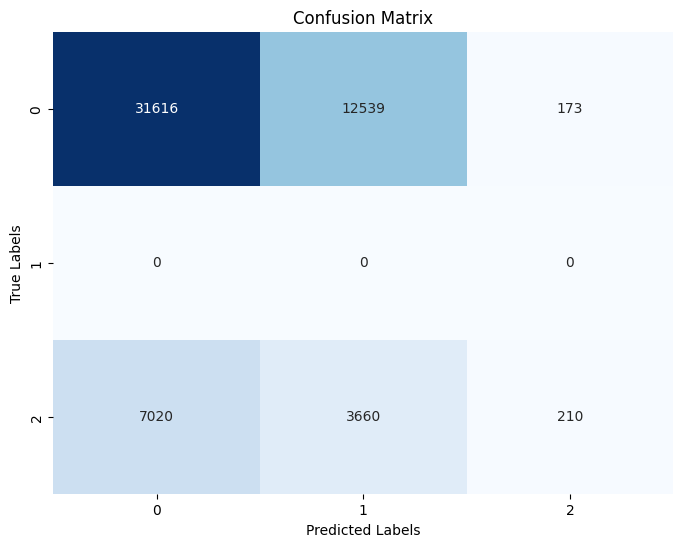

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, preds, average='macro')
print("Recall:", recall)

precision = precision_score(y_test, preds, average='macro')
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(y_test, preds, average='macro')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Save the model as .tflite

Convert the model into Tensorflow Lite format:


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfl_model = converter.convert()

Show model size in KBs:

In [ ]:
float_model_size = len(tfl_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 2KBs.


Save:

In [ ]:
with open('./model_without_metadata/gasnet.tflite', 'wb') as file:
  file.write(tfl_model)

## Model [optimization](https://www.tensorflow.org/lite/models/build#model_optimization)

With the constraints on resources specific to TensorFlow Lite models, model optimization can help to ensure your model performance well and uses less compute resources. Machine learning model performance is usually a balance between size and speed of inference vs accuracy. TensorFlow Lite currently supports optimization via quantization, pruning and clustering. See the model optimization topic for more details on these techniques. TensorFlow also provides a Model optimization toolkit which provides an API that implements these techniques.

Quantization is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 2KBs,
which is about 100% of the float model size.


#### [Evaluate](https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb#scrollTo=ahTP3T60nYJb) the float model and the quantized model

## [Adding metadata to the tflite model](https://www.tensorflow.org/lite/models/convert/metadata)

In [ ]:
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata

Need to edit [metadata_writer.py](https://drive.google.com/file/d/1_xjQKQ6K08Xw6COO3cLBbaAm1BH3YFSx/view?usp=drive_link) file according to the metadata added to the model. Pay attention to parameters such as:
*   Min, max, std, mean values
*   Model and metadata description
*   Input and output tensor description


If '**model_with_metadata**' directory is not empty, delete the files in it. And re-run the following line again.

In [ ]:
!python ./model_without_metadata/metadata_writer.py \
    --model_file=./model_without_metadata/gasnet.tflite \
    --label_file=./model_without_metadata/labels.txt \
    --export_directory=model_with_metadata

2023-07-14 08:44:31.846553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Finished populating metadata and associated file to the model:
./model_without_metadata/gasnet.tflite
The metadata json file has been saved to:
model_with_metadata/gasnet.json
The associated file that has been been packed to the model is:
['labels.txt']


## [Code generator](https://www.tensorflow.org/lite/inference_with_metadata/codegen#codegen)
Test for integrating the model to Android app

**Create a Android module**:

If '**gas_classification**' directory is not empty, delete the files in it. And re-run the following line again.

In [ ]:
!tflite_codegen --model=./model_with_metadata/gasnet.tflite  \
    --package_name=org.tensorflow.lite.support.gasclassification \
    --model_class_name=GasDetectorModel \
    --destination=./gas_classification

I0714 08:57:55.709635 132120921433920 codegen.py:88] Generation succeeded!
I0714 08:57:55.716797 132120921433920 codegen.py:93] Model copied into assets!


In [ ]:
# Zip up the generated code
!zip -r gas_classification_v51.zip gas_classification/

# Download the archive
from google.colab import files
files.download('gas_classification_v51.zip')

# v0: Test the first time integration
# v1: Complete to fix Writer_script. 2nd integration
# v2: Add the data from phone
# v3: Add 2 specimens
# v4: Edit from scratch. Build model with data from phone. Test with 4 smells (na,cf,fcf,scl vs 6700 samples)
# v5: Test with 4 smells (na,cf,fcf,scl vs 10000 samples)
# v5.1: Test with 3 smells (na,cf,fcf vs 6000 samples; data processing in every 10s)

updating: gas_classification/ (stored 0%)
updating: gas_classification/src/ (stored 0%)
updating: gas_classification/src/main/ (stored 0%)
updating: gas_classification/src/main/java/ (stored 0%)
updating: gas_classification/src/main/java/org/ (stored 0%)
updating: gas_classification/src/main/java/org/tensorflow/ (stored 0%)
updating: gas_classification/src/main/java/org/tensorflow/lite/ (stored 0%)
updating: gas_classification/src/main/java/org/tensorflow/lite/support/ (stored 0%)
updating: gas_classification/src/main/java/org/tensorflow/lite/support/gasclassification/ (stored 0%)
updating: gas_classification/src/main/java/org/tensorflow/lite/support/gasclassification/GasDetectorModel.java (deflated 79%)
updating: gas_classification/src/main/AndroidManifest.xml (deflated 24%)
updating: gas_classification/src/main/assets/ (stored 0%)
updating: gas_classification/src/main/assets/gasnet.tflite (deflated 42%)
updating: gas_classification/build.gradle (deflated 60%)
updating: gas_classifica

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Add the model as a Android module to app

The first step is to unzip the downloaded file.

### Fix the module setting errors

a. Process the 'gas_classification_v[number of version]/build.gradle' file as follows:

- Comment the follow lines:


```
allprojects {
    repositories {
//        google()
//        mavenCentral()
//        flatDir {
//            dirs 'libs'
//        }
    }
}
...
/*
configurations {
    libMetadata
}

dependencies {
    libMetadata 'org.tensorflow:tensorflow-lite-support:0.0.0-experimental-metadata-monolithic'
}

task downloadLibs(type: Sync) {
    from configurations.libMetadata
    into "$buildDir/libs"
    rename 'tensorflow-lite-support-0.0.0-experimental-metadata-monolithic.jar', "tensorflow-lite-support-metadata.jar"
}

preBuild.dependsOn downloadLibs
*/
```



- Add namespace and update SdkVersion:

```
android {
    namespace 'com.example.ainose'
    compileSdkVersion 33
    defaultConfig {
        minSdk 24
        targetSdkVersion 33
        versionCode 1
        versionName "1.0"
    }
    ...
}
```



- Add dependencies:

```
dependencies {
    compileOnly 'org.checkerframework:checker-qual:2.5.8'
    api 'org.tensorflow:tensorflow-lite:2.12.0'
    api 'org.tensorflow:tensorflow-lite-support:0.4.3'
    api 'org.tensorflow:tensorflow-lite-metadata:0.4.3'
    implementation 'org.apache.commons:commons-compress:1.23.0'
}
```



b. Delete the reduntdant line in 'gas_classification_v[version]/src/main/**AndroidManifest.xml**' file.

c. Fix code
- create a **byteToDataTypeConverter()** function
- concert the QuantizationParams library

d. Remove the implementation of the **old** gas_classification module from the dependencies section in the '/app/**build.gradle**' file.

Eg:

```
dependencies {
    // implementation project(path: ':gas_classification_v2')
    // implementation project(path: ':gas_classification_v31')
    implementation project(path: ':gas_classification_v4')
}
```



e. Run and fix other errors if any

## Edit the app's source code logic if necessary

## Done
😀 😀 😀 Enjoy the result!!!